In [1]:
import gdown
gdown.download(id='13efSxw7Sv7rvjSlyIu6nARhOX8UuYD9i')
!unzip 02_Systems_Cognitive-20230717T224149Z-002.zip
!rm 02_Systems_Cognitive-20230717T224149Z-002.zip
!mv 02_Systems_Cognitive Data/
!ls Data/02_Systems_Cognitive/

Downloading...
From: https://drive.google.com/uc?id=13efSxw7Sv7rvjSlyIu6nARhOX8UuYD9i
To: /content/02_Systems_Cognitive-20230717T224149Z-002.zip
100%|██████████| 334M/334M [00:05<00:00, 64.9MB/s]


Archive:  02_Systems_Cognitive-20230717T224149Z-002.zip
  inflating: 02_Systems_Cognitive/travelling_brain_waves/fsLR_32k_Schaefer200-rh.txt  
  inflating: 02_Systems_Cognitive/travelling_brain_waves/fsLR_32k_midthickness-lh_eval_50.txt  
  inflating: 02_Systems_Cognitive/whobpyt/LICENSE  
  inflating: 02_Systems_Cognitive/whobpyt/setup.py  
  inflating: 02_Systems_Cognitive/whobpyt/install_colab.py  
  inflating: 02_Systems_Cognitive/travelling_brain_waves/fsLR_32k_midthickness-rh_eval_50.txt  
  inflating: 02_Systems_Cognitive/Robinson_model/SynPy/requirements.txt  
  inflating: 02_Systems_Cognitive/whobpyt/.gitignore  
  inflating: 02_Systems_Cognitive/Robinson_model/SynPy/main.py  
  inflating: 02_Systems_Cognitive/Robinson_model/SynPy/setup.py  
  inflating: 02_Systems_Cognitive/Robinson_model/SynPy/eirs-tms-custom.conf  
  inflating: 02_Systems_Cognitive/whobpyt/README.rst  
  inflating: 02_Systems_Cognitive/travelling_brain_waves/fsLR_32kmidthickness-lh.gii  
  inflating: 02_Sys

In [2]:
import gdown

gdown.download(id='1TnYzAnouh3cA0pD6ad-SNGHQqRCHbyh8')
!mv /content/sub-02_run-01_fittingresults_stim_exp.pkl /content/Data/EEG_stim/

Downloading...
From: https://drive.google.com/uc?id=1TnYzAnouh3cA0pD6ad-SNGHQqRCHbyh8
To: /content/sub-02_run-01_fittingresults_stim_exp.pkl
100%|██████████| 2.30G/2.30G [00:27<00:00, 84.9MB/s]


***Dr. Davide Momi***<br/>
​-----------<br/>
Post-Doctoral Research Fellow<br/>
Whole Brain Modelling Group<br/>
Krembil Centre for Neuroinformatics - CAMH<br/>
250 College St., Toronto, ON M5T 1R8<br/>
website: https://davi1990.github.io/<br/>
Twitter: @DaveMomi<br/>

## Setup

If you are running this notebook in Google Colab, you will need to install some packages. If you are running in a more standard python environment, you need to ensure that these packages are installed externally (typically with `pip install <package>` on the command line).

In [3]:
import sys
import os


!{sys.executable} -m pip install mne > /dev/null
!{sys.executable} -m pip install nilearn > /dev/null
!{sys.executable} -m pip install nibabel > /dev/null
!{sys.executable} -m pip install tvb-data > /dev/null
!{sys.executable} -m pip install tvb-library > /dev/null
!{sys.executable} -m pip install fooof > /dev/null

# @title Install dependencies

In [4]:
import warnings
warnings.filterwarnings("ignore")

%pylab inline

from scipy import signal
from scipy.signal import welch
from tvb.simulator.lab import *
from tvb.basic.neotraits.api import NArray, List, Range, Final
import numpy as np
import scipy.io as sio
import scipy.signal as sig
from scipy.stats import zscore
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import multiprocessing as mp
from matplotlib.gridspec import GridSpec
from PIL import Image
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
import os


import warnings
warnings.filterwarnings("ignore")

# @title Import packages

Populating the interactive namespace from numpy and matplotlib


In [5]:
import os
import sys
%pylab inline
from scipy import signal
from scipy.signal import welch
from tvb.simulator.lab import *
from tvb.basic.neotraits.api import NArray, List, Range, Final
import scipy.io as sio
import scipy.signal as sig
from scipy.stats import zscore
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import multiprocessing as mp
from matplotlib.gridspec import GridSpec
from PIL import Image
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
import os


import warnings
warnings.filterwarnings("ignore")


os.chdir('/content/Data/whobpyt/')

sys.path.append('/content/Data/whobpyt/')
import pandas as pd
import numpy as np
import mne
import pickle
import scipy.signal as signal
from whobpyt.optimization.modelfitting import Model_fitting
from whobpyt.datatypes.modelparameters import ParamsModel
import torch

import warnings
warnings.filterwarnings('ignore')

from nilearn import plotting
from nilearn import datasets
from nibabel.freesurfer.io import read_annot

import requests
import os

def download_file(url, save_path):
    file_name = url.split('/')[-1]  # Extract the file name from the URL
    file_path = os.path.join(save_path, file_name)  # Create the complete file path
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:  # Filter out keep-alive new chunks
                    file.write(chunk)
    print(f"File '{file_name}' downloaded successfully.")


class RNNJANSEN(torch.nn.Module):
    """
    A module for forward model (JansenRit) to simulate a batch of EEG signals
    Attibutes
    ---------
    state_size : int
        the number of states in the JansenRit model
    input_size : int
        the number of states with noise as input
    tr : float
        tr of image
    step_size: float
        Integration step for forward model
    hidden_size: int
        the number of step_size in a tr
    TRs_per_window: int
        the number of EEG signals to simulate
    node_size: int
        the number of ROIs
    sc: float node_size x node_size array
        structural connectivity
    fit_gains: bool
        flag for fitting gains 1: fit 0: not fit
    g, c1, c2, c3,c4: tensor with gradient on
        model parameters to be fit
    w_bb: tensor with node_size x node_size (grad on depends on fit_gains)
        connection gains
    std_in std_out: tensor with gradient on
        std for state noise and output noise
    hyper parameters for prior distribution of model parameters
    Methods
    -------
    forward(input, noise_out, hx)
        forward model (JansenRit) for generating a number of EEG signals with current model parameters
    """
    state_names = ['E', 'Ev', 'I', 'Iv', 'P', 'Pv']
    model_name = "JR"

    def __init__(self, node_size: int,
                 TRs_per_window: int, step_size: float, output_size: int, tr: float, sc: float, lm: float, dist: float,
                 use_fit_gains: bool, use_fit_lfm: bool, param: ParamsModel) -> None:
        """
        Parameters
        ----------

        tr : float
            tr of image
        step_size: float
            Integration step for forward model

        TRs_per_window: int
            the number of EEG signals to simulate
        node_size: int
            the number of ROIs
        output_size: int
            the number of channels EEG
        sc: float node_size x node_size array
            structural connectivity
        use_fit_gains: bool
            flag for fitting gains 1: fit 0: not fit
        use_fit_lfm: bool
            flag for fitting gains 1: fit 0: not fit
        param from ParamJR
        """
        super(RNNJANSEN, self).__init__()
        self.state_size = 6  # 6 states JR model
        self.tr = tr  # tr ms (integration step 0.1 ms)
        self.step_size = torch.tensor(step_size, dtype=torch.float32)  # integration step 0.1 ms
        self.steps_per_TR = int(tr / step_size)
        self.TRs_per_window = TRs_per_window  # size of the batch used at each step
        self.node_size = node_size  # num of ROI
        self.output_size = output_size  # num of EEG channels
        self.sc = sc  # matrix node_size x node_size structure connectivity
        self.dist = torch.tensor(dist, dtype=torch.float32)
        self.lm = lm
        self.use_fit_gains = use_fit_gains  # flag for fitting gains
        self.use_fit_lfm = use_fit_lfm
        self.param = param

        self.output_size = lm.shape[0]  # number of EEG channels

    def setModelParameters(self):
        # set states E I f v mean and 1/sqrt(variance)
        return setModelParameters(self)

    def forward(self, external, hx, hE):
        return integration_forward(self, external, hx, hE)


from torch.nn.parameter import Parameter
import torch


def sys2nd(A, a, u, x, v):
    return A * a * u - 2 * a * v - a ** 2 * x


def sigmoid(x, vmax, v0, r):
    return vmax / (1 + torch.exp(r * (v0 - x)))


def h_tf(a, b, d, z):
    """
    Neuronal input-output functions of excitatory pools and inhibitory pools.
    Take the variables a, x, and b and convert them to a linear equation (a*x - b) while adding a small
    amount of noise 0.00001 while dividing that term to an exponential of the linear equation multiplied by the
    d constant for the appropriate dimensions.
    """
    num = 0.00001 + torch.abs(a * z - b)
    den = 0.00001 * d + torch.abs(1.0000 - torch.exp(-d * (a * z - b)))
    return torch.divide(num, den)


def setModelParameters(model):
    if model.model_name == 'RWW':
        if model.use_Gaussian_EI:
            model.E_m = Parameter(torch.tensor(0.16, dtype=torch.float32))
            model.I_m = Parameter(torch.tensor(0.1, dtype=torch.float32))
            # model.f_m = Parameter(torch.tensor(1.0, dtype=torch.float32))
            model.v_m = Parameter(torch.tensor(1.0, dtype=torch.float32))
            # model.x_m = Parameter(torch.tensor(0.16, dtype=torch.float32))
            model.q_m = Parameter(torch.tensor(1.0, dtype=torch.float32))

            model.E_v_inv = Parameter(torch.tensor(2500, dtype=torch.float32))
            model.I_v_inv = Parameter(torch.tensor(2500, dtype=torch.float32))
            # model.f_v = Parameter(torch.tensor(100, dtype=torch.float32))
            model.v_v_inv = Parameter(torch.tensor(100, dtype=torch.float32))
            # model.x_v = Parameter(torch.tensor(100, dtype=torch.float32))
            model.q_v_inv = Parameter(torch.tensor(100, dtype=torch.float32))

        # hyper parameters (variables: need to calculate gradient) to fit density
        # of gEI and gIE (the shape from the bifurcation analysis on an isolated node)
        if model.use_Bifurcation:
            model.sup_ca = Parameter(torch.tensor(0.5, dtype=torch.float32))
            model.sup_cb = Parameter(torch.tensor(20, dtype=torch.float32))
            model.sup_cc = Parameter(torch.tensor(10, dtype=torch.float32))

        # set gains_con as Parameter if fit_gain is True
        if model.use_fit_gains:
            model.gains_con = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                     dtype=torch.float32))  # connenction gain to modify empirical sc
        else:
            model.gains_con = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)

        vars_name = [a for a in dir(model.param) if not a.startswith('__') and not callable(getattr(model.param, a))]
        for var in vars_name:
            if np.any(getattr(model.param, var)[1] > 0):
                setattr(model, var, Parameter(
                    torch.tensor(getattr(model.param, var)[0] + getattr(model.param, var)[1] * np.random.randn(1, )[0],
                                 dtype=torch.float32)))
                if model.use_Bifurcation:
                    if var not in ['std_in', 'g_IE', 'g_EI']:
                        dict_nv = {'m': getattr(model.param, var)[0], 'v': 1 / (getattr(model.param, var)[1]) ** 2}

                        dict_np = {'m': var + '_m', 'v': var + '_v_inv'}

                        for key in dict_nv:
                            setattr(model, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
                else:
                    if var not in ['std_in']:
                        dict_nv = {'m': getattr(model.param, var)[0], 'v': 1 / (getattr(model.param, var)[1]) ** 2}

                        dict_np = {'m': var + '_m', 'v': var + '_v_inv'}

                        for key in dict_nv:
                            setattr(model, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
            else:
                setattr(model, var, torch.tensor(getattr(model.param, var)[0], dtype=torch.float32))

    if model.model_name == 'JR':
        # set model parameters (variables: need to calculate gradient) as Parameter others : tensor
        # set w_bb as Parameter if fit_gain is True
        if model.use_fit_gains:
            model.w_bb = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                dtype=torch.float32))  # connenction gain to modify empirical sc
            model.w_ff = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                dtype=torch.float32))
            model.w_ll = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                dtype=torch.float32))
        else:
            model.w_bb = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)
            model.w_ff = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)
            model.w_ll = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)

        if model.use_fit_lfm:
            model.lm = Parameter(torch.tensor(model.lm, dtype=torch.float32))  # leadfield matrix from sourced data to eeg
        else:
            model.lm = torch.tensor(model.lm, dtype=torch.float32)  # leadfield matrix from sourced data to eeg

        vars_name = [a for a in dir(model.param) if not a.startswith('__') and not callable(getattr(model.param, a))]
        for var in vars_name:
            if np.any(getattr(model.param, var)[1] > 0):
                # print(type(getattr(param, var)[1]))
                if type(getattr(model.param, var)[1]) is np.ndarray:
                    if var == 'lm':
                        size = getattr(model.param, var)[1].shape
                        setattr(model, var, Parameter(
                            torch.tensor(getattr(model.param, var)[0] - 1 * np.ones((size[0], size[1])),
                                         dtype=torch.float32)))
                        print(getattr(model, var))
                    else:
                        size = getattr(model.param, var)[1].shape
                        setattr(model, var, Parameter(
                            torch.tensor(
                                getattr(model.param, var)[0] + getattr(model.param, var)[1] * np.random.randn(size[0], size[1]),
                                dtype=torch.float32)))
                        # print(getattr(self, var))
                else:
                    setattr(model, var, Parameter(
                        torch.tensor(getattr(model.param, var)[0] + getattr(model.param, var)[1] * np.random.randn(1, )[0],
                                     dtype=torch.float32)))
                if var != 'std_in':
                    dict_nv = {'m': getattr(model.param, var)[0], 'v': 1 / (getattr(model.param, var)[1]) ** 2}

                    dict_np = {'m': var + '_m', 'v': var + '_v_inv'}

                    for key in dict_nv:
                        setattr(model, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
            else:
                setattr(model, var, torch.tensor(getattr(model.param, var)[0], dtype=torch.float32))

    if model.model_name == 'LIN':
        # set gains_con as Parameter if fit_gain is True
        if model.use_fit_gains:
            model.gains_con = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                     dtype=torch.float32))  # connenction gain to modify empirical sc
        else:
            model.gains_con = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)

        vars_name = [a for a in dir(model.param) if not a.startswith('__') and not callable(getattr(model.param, a))]
        for var in vars_name:
            if np.any(getattr(model.param, var)[1] > 0):
                setattr(model, var, Parameter(
                    torch.tensor(getattr(model.param, var)[0] + getattr(model.param, var)[1] * np.random.randn(1, )[0],
                                 dtype=torch.float32)))

                if var not in ['std_in']:
                    dict_nv = {'m': getattr(model.param, var)[0], 'v': 1 / (getattr(model.param, var)[1]) ** 2}

                    dict_np = {'m': var + '_m', 'v': var + '_v_inv'}

                    for key in dict_nv:
                        setattr(model, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
            else:
                setattr(model, var, torch.tensor(getattr(model.param, var)[0], dtype=torch.float32))


def integration_forward(model, external, hx, hE):
    if model.model_name == 'RWW':
        """
        Forward step in simulating the BOLD signal.
        Parameters
        ----------
        external: tensor with node_size x steps_per_TR x TRs_per_window x input_size
            noise for states

        hx: tensor with node_size x state_size
            states of WWD model
        Outputs
        -------
        next_state: dictionary with keys:
        'current_state''bold_window''E_window''I_window''x_window''f_window''v_window''q_window'
            record new states and BOLD
        """
        next_state = {}

        # hx is current state (6) 0: E 1:I (neural activities) 2:x 3:f 4:v 5:f (BOLD)

        x = hx[:, 2:3]
        f = hx[:, 3:4]
        v = hx[:, 4:5]
        q = hx[:, 5:6]

        dt = torch.tensor(model.step_size, dtype=torch.float32)

        # Generate the ReLU module for model parameters gEE gEI and gIE
        m = torch.nn.ReLU()

        # Update the Laplacian based on the updated connection gains gains_con.
        if model.sc.shape[0] > 1:

            # Update the Laplacian based on the updated connection gains gains_con.
            sc_mod = torch.exp(model.gains_con) * torch.tensor(model.sc, dtype=torch.float32)
            sc_mod_normalized = (0.5 * (sc_mod + torch.transpose(sc_mod, 0, 1))) / torch.linalg.norm(
                0.5 * (sc_mod + torch.transpose(sc_mod, 0, 1)))
            model.sc_fitted = sc_mod_normalized

            if model.use_Laplacian:
                lap_adj = -torch.diag(sc_mod_normalized.sum(1)) + sc_mod_normalized
            else:
                lap_adj = sc_mod_normalized

        else:
            lap_adj = torch.tensor(np.zeros((1, 1)), dtype=torch.float32)

        # placeholder for the updated current state
        current_state = torch.zeros_like(hx)

        # placeholders for output BOLD, history of E I x f v and q
        # placeholders for output BOLD, history of E I x f v and q
        bold_window = torch.zeros((model.node_size, model.TRs_per_window))
        # E_window = torch.zeros((model.node_size,model.TRs_per_window))
        # I_window = torch.zeros((model.node_size,model.TRs_per_window))

        x_window = torch.zeros((model.node_size, model.TRs_per_window))
        f_window = torch.zeros((model.node_size, model.TRs_per_window))
        v_window = torch.zeros((model.node_size, model.TRs_per_window))
        q_window = torch.zeros((model.node_size, model.TRs_per_window))

        E_hist = torch.zeros((model.node_size, model.TRs_per_window, model.steps_per_TR))
        I_hist = torch.zeros((model.node_size, model.TRs_per_window, model.steps_per_TR))
        E_mean = hx[:, 0:1]
        I_mean = hx[:, 1:2]
        # print(E_m.shape)
        # Use the forward model to get neural activity at ith element in the window.
        if model.use_dynamic_boundary:
            for TR_i in range(model.TRs_per_window):

                # print(E.shape)

                # Since tr is about second we need to use a small step size like 0.05 to integrate the model states.
                for step_i in range(model.steps_per_TR):
                    E = torch.zeros((model.node_size, model.sampling_size))
                    I = torch.zeros((model.node_size, model.sampling_size))
                    for sample_i in range(model.sampling_size):
                        E[:, sample_i] = E_mean[:, 0] + 0.02 * torch.randn(model.node_size)
                        I[:, sample_i] = I_mean[:, 0] + 0.001 * torch.randn(model.node_size)

                    # Calculate the input recurrent.
                    IE = torch.tanh(m(model.W_E * model.I_0 + (0.001 + m(model.g_EE)) * E
                                      + model.g * torch.matmul(lap_adj, E) - (
                                              0.001 + m(model.g_IE)) * I))  # input currents for E
                    II = torch.tanh(m(model.W_I * model.I_0 + (0.001 + m(model.g_EI)) * E - I))  # input currents for I

                    # Calculate the firing rates.
                    rE = h_tf(model.aE, model.bE, model.dE, IE)  # firing rate for E
                    rI = h_tf(model.aI, model.bI, model.dI, II)  # firing rate for I
                    # Update the states by step-size 0.05.
                    E_next = E + dt * (-E * torch.reciprocal(model.tau_E) + model.gamma_E * (1. - E) * rE) \
                             + torch.sqrt(dt) * torch.randn(model.node_size, model.sampling_size) * (0.02 + m(
                        model.std_in))  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)
                    I_next = I + dt * (-I * torch.reciprocal(model.tau_I) + model.gamma_I * rI) \
                             + torch.sqrt(dt) * torch.randn(model.node_size, model.sampling_size) * (
                                     0.02 + m(model.std_in))

                    # Calculate the saturation for model states (for stability and gradient calculation).

                    # E_next[E_next>=0.9] = torch.tanh(1.6358*E_next[E_next>=0.9])
                    E = torch.tanh(0.0000 + m(1.0 * E_next))
                    I = torch.tanh(0.0000 + m(1.0 * I_next))

                    I_mean = I.mean(1)[:, np.newaxis]
                    E_mean = E.mean(1)[:, np.newaxis]
                    I_mean[I_mean < 0.00001] = 0.00001
                    E_mean[E_mean < 0.00001] = 0.00001

                    E_hist[:, TR_i, step_i] = E_mean[:, 0]
                    I_hist[:, TR_i, step_i] = I_mean[:, 0]

            for TR_i in range(model.TRs_per_window):

                for step_i in range(model.steps_per_TR):
                    x_next = x + 1 * dt * (1 * E_hist[:, TR_i, step_i][:, np.newaxis] - torch.reciprocal(
                        model.tau_s) * x - torch.reciprocal(model.tau_f) * (f - 1))
                    f_next = f + 1 * dt * x
                    v_next = v + 1 * dt * (f - torch.pow(v, torch.reciprocal(model.alpha))) * torch.reciprocal(
                        model.tau_0)
                    q_next = q + 1 * dt * (
                            f * (1 - torch.pow(1 - model.rho, torch.reciprocal(f))) * torch.reciprocal(
                        model.rho) - q * torch.pow(v, torch.reciprocal(model.alpha)) * torch.reciprocal(v)) \
                             * torch.reciprocal(model.tau_0)

                    x = torch.tanh(x_next)
                    f = (1 + torch.tanh(f_next - 1))
                    v = (1 + torch.tanh(v_next - 1))
                    q = (1 + torch.tanh(q_next - 1))
                    # Put x f v q from each tr to the placeholders for checking them visually.
                x_window[:, TR_i] = x[:, 0]
                f_window[:, TR_i] = f[:, 0]
                v_window[:, TR_i] = v[:, 0]
                q_window[:, TR_i] = q[:, 0]

                # Put the BOLD signal each tr to the placeholder being used in the cost calculation.

                bold_window[:, TR_i] = ((0.00 + m(model.std_out)) * torch.randn(model.node_size, 1) +
                                        100.0 * model.V * torch.reciprocal(model.E0) *
                                        (model.k1 * (1 - q) + model.k2 * (1 - q * torch.reciprocal(v)) + model.k3 * (
                                                1 - v)))[:, 0]
        else:

            for TR_i in range(model.TRs_per_window):

                # print(E.shape)

                # Since tr is about second we need to use a small step size like 0.05 to integrate the model states.
                for step_i in range(model.steps_per_TR):
                    E = torch.zeros((model.node_size, model.sampling_size))
                    I = torch.zeros((model.node_size, model.sampling_size))
                    for sample_i in range(model.sampling_size):
                        E[:, sample_i] = E_mean[:, 0] + 0.001 * torch.randn(model.node_size)
                        I[:, sample_i] = I_mean[:, 0] + 0.001 * torch.randn(model.node_size)

                    # Calculate the input recurrent.
                    IE = 1 * torch.tanh(m(model.W_E * model.I_0 + (0.001 + m(model.g_EE)) * E \
                                          + model.g * torch.matmul(lap_adj, E) - (
                                                  0.001 + m(model.g_IE)) * I))  # input currents for E
                    II = 1 * torch.tanh(
                        m(model.W_I * model.I_0 + (0.001 + m(model.g_EI)) * E - I))  # input currents for I

                    # Calculate the firing rates.
                    rE = h_tf(model.aE, model.bE, model.dE, IE)  # firing rate for E
                    rI = h_tf(model.aI, model.bI, model.dI, II)  # firing rate for I
                    # Update the states by step-size 0.05.
                    E_next = E + dt * (-E * torch.reciprocal(model.tau_E) + model.gamma_E * (1. - E) * rE) \
                             + torch.sqrt(dt) * torch.randn(model.node_size, model.sampling_size) * (0.02 + m(
                        model.std_in))  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)
                    I_next = I + dt * (-I * torch.reciprocal(model.tau_I) + model.gamma_I * rI) \
                             + torch.sqrt(dt) * torch.randn(model.node_size, model.sampling_size) * (
                                     0.02 + m(model.std_in))

                    # Calculate the saturation for model states (for stability and gradient calculation).
                    E_next[E_next < 0.00001] = 0.00001
                    I_next[I_next < 0.00001] = 0.00001
                    # E_next[E_next>=0.9] = torch.tanh(1.6358*E_next[E_next>=0.9])
                    E = E_next  # torch.tanh(0.00001+m(1.0*E_next))
                    I = I_next  # torch.tanh(0.00001+m(1.0*I_next))

                    I_mean = I.mean(1)[:, np.newaxis]
                    E_mean = E.mean(1)[:, np.newaxis]
                    E_hist[:, TR_i, step_i] = torch.tanh(E_mean)[:, 0]
                    I_hist[:, TR_i, step_i] = torch.tanh(I_mean)[:, 0]

                # E_window[:,TR_i]=E_mean[:,0]
                # I_window[:,TR_i]=I_mean[:,0]

            for TR_i in range(model.TRs_per_window):

                for step_i in range(model.steps_per_TR):
                    x_next = x + 1 * dt * (1 * E_hist[:, TR_i, step_i][:, np.newaxis] - torch.reciprocal(
                        model.tau_s) * x - torch.reciprocal(model.tau_f) * (f - 1))
                    f_next = f + 1 * dt * x
                    v_next = v + 1 * dt * (f - torch.pow(v, torch.reciprocal(model.alpha))) * torch.reciprocal(
                        model.tau_0)
                    q_next = q + 1 * dt * (
                            f * (1 - torch.pow(1 - model.rho, torch.reciprocal(f))) * torch.reciprocal(
                        model.rho) - q * torch.pow(v, torch.reciprocal(model.alpha)) * torch.reciprocal(v)) \
                             * torch.reciprocal(model.tau_0)

                    f_next[f_next < 0.001] = 0.001
                    v_next[v_next < 0.001] = 0.001
                    q_next[q_next < 0.001] = 0.001
                    x = x_next  # torch.tanh(x_next)
                    f = f_next  # (1 + torch.tanh(f_next - 1))
                    v = v_next  # (1 + torch.tanh(v_next - 1))
                    q = q_next  # (1 + torch.tanh(q_next - 1))
                # Put x f v q from each tr to the placeholders for checking them visually.
                x_window[:, TR_i] = x[:, 0]
                f_window[:, TR_i] = f[:, 0]
                v_window[:, TR_i] = v[:, 0]
                q_window[:, TR_i] = q[:, 0]
                # Put the BOLD signal each tr to the placeholder being used in the cost calculation.

                bold_window[:, TR_i] = ((0.00 + m(model.std_out)) * torch.randn(model.node_size, 1) +
                                        100.0 * model.V * torch.reciprocal(
                            model.E0) * (model.k1 * (1 - q) + model.k2 * (
                                1 - q * torch.reciprocal(v)) + model.k3 * (1 - v)))[:, 0]

        # Update the current state.
        # print(E_m.shape)
        current_state = torch.cat([E_mean, I_mean, x, f, v, q], dim=1)
        next_state['current_state'] = current_state
        next_state['bold_window'] = bold_window
        next_state['E_window'] = E_hist.reshape((model.node_size, -1))
        next_state['I_window'] = I_hist.reshape((model.node_size, -1))
        next_state['x_window'] = x_window
        next_state['f_window'] = f_window
        next_state['v_window'] = v_window
        next_state['q_window'] = q_window

        return next_state, hE

    if model.model_name == 'JR':

        # define some constants
        conduct_lb = 1.5  # lower bound for conduct velocity
        u_2ndsys_ub = 500  # the bound of the input for second order system
        noise_std_lb = 150  # lower bound of std of noise
        lb = 0.01  # lower bound of local gains
        s2o_coef = 0.0001  # coefficient from states (source EEG) to EEG
        k_lb = 0.5  # lower bound of coefficient of external inputs

        next_state = {}

        M = hx[:, 0:1]  # current of main population
        E = hx[:, 1:2]  # current of excitory population
        I = hx[:, 2:3]  # current of inhibitory population

        Mv = hx[:, 3:4]  # voltage of main population
        Ev = hx[:, 4:5]  # voltage of exictory population
        Iv = hx[:, 5:6]  # voltage of inhibitory population

        dt = model.step_size
        # Generate the ReLU module for model parameters gEE gEI and gIE

        m = torch.nn.ReLU()

        # define constant 1 tensor
        con_1 = torch.tensor(1.0, dtype=torch.float32)
        if model.sc.shape[0] > 1:

            # Update the Laplacian based on the updated connection gains w_bb.
            w_b = torch.exp(model.w_bb) * torch.tensor(model.sc, dtype=torch.float32)
            w_n_b = w_b / torch.linalg.norm(w_b)

            model.sc_m_b = w_n_b
            dg_b = -torch.diag(torch.sum(w_n_b, dim=1))
            # Update the Laplacian based on the updated connection gains w_bb.
            w_f = torch.exp(model.w_ff) * torch.tensor(model.sc, dtype=torch.float32)
            w_n_f = w_f / torch.linalg.norm(w_f)

            model.sc_m_f = w_n_f
            dg_f = -torch.diag(torch.sum(w_n_f, dim=1))
            # Update the Laplacian based on the updated connection gains w_bb.
            w = torch.exp(model.w_ll) * torch.tensor(model.sc, dtype=torch.float32)
            w_n_l = (0.5 * (w + torch.transpose(w, 0, 1))) / torch.linalg.norm(
                0.5 * (w + torch.transpose(w, 0, 1)))

            model.sc_fitted = w_n_l
            dg_l = -torch.diag(torch.sum(w_n_l, dim=1))
        else:
            l_s = torch.tensor(np.zeros((1, 1)), dtype=torch.float32)
            dg_l = 0
            dg_b = 0
            dg_f = 0
            w_n_l = 0
            w_n_b = 0
            w_n_f = 0

        model.delays = (model.dist / (conduct_lb * con_1 + m(model.mu))).type(torch.int64)
        # print(torch.max(model.delays), model.delays.shape)

        # placeholder for the updated current state
        current_state = torch.zeros_like(hx)

        # placeholders for output BOLD, history of E I x f v and q
        eeg_window = []
        E_window = []
        I_window = []
        M_window = []
        Ev_window = []
        Iv_window = []
        Mv_window = []

        # Use the forward model to get EEG signal at ith element in the window.
        for i_window in range(model.TRs_per_window):

            for step_i in range(model.steps_per_TR):
                Ed = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)  # delayed E

                """for ind in range(model.node_size):
                    #print(ind, hE[ind,:].shape, model.delays[ind,:].shape)
                    Ed[ind] = torch.index_select(hE[ind,:], 0, model.delays[ind,:])"""
                hE_new = hE.clone()
                Ed = hE_new.gather(1, model.delays)  # delayed E

                LEd_b = torch.reshape(torch.sum(w_n_b * torch.transpose(Ed, 0, 1), 1),
                                      (model.node_size, 1))  # weights on delayed E
                LEd_f = torch.reshape(torch.sum(w_n_f * torch.transpose(Ed, 0, 1), 1),
                                      (model.node_size, 1))  # weights on delayed E
                LEd_l = torch.reshape(torch.sum(w_n_l * torch.transpose(Ed, 0, 1), 1),
                                      (model.node_size, 1))  # weights on delayed E
                # Input noise for M.

                u_tms = external[:, step_i:step_i + 1, i_window]
                #u_aud = external[:, i_hidden:i_hidden + 1, i_window, 1]
                #u_0 = external[:, i_hidden:i_hidden + 1, i_window, 2]

                # LEd+torch.matmul(dg,E): Laplacian on delayed E

                rM = (0.0+m(model.k0))+ (k_lb * con_1 + m(model.k)) * m(model.ki)* u_tms + \
                     (20 * con_1 + torch.exp(model.std_in)) * torch.randn(model.node_size, 1) + \
                     1 * (lb * con_1 + m(model.g)) * (
                             LEd_l + 1 * torch.matmul(dg_l, M)) + \
                     sigmoid(E - I, model.vmax, model.v0, model.r)  # firing rate for Main population
                rE = (20 * con_1 + torch.exp(model.std_in)) * torch.randn(model.node_size, 1) + \
                     1 * (lb * con_1 + m(model.g_f)) * (LEd_f + 1 * torch.matmul(dg_f, E - I)) + \
                     (lb * con_1 + m(model.c2)) * sigmoid((lb * con_1 + m(model.c1)) * M, model.vmax, model.v0,
                                                          model.r)  # firing rate for Excitory population
                rI = (20* con_1 + torch.exp(model.std_in)) * torch.randn(model.node_size, 1) + \
                     1 * (lb * con_1 + m(model.g_b)) * (-LEd_b - 1 * torch.matmul(dg_b, E - I)) + \
                     (lb * con_1 + m(model.c4)) * sigmoid((lb * con_1 + m(model.c3)) * M, model.vmax, model.v0,
                                                          model.r)  # firing rate for Inhibitory population

                # Update the states by step-size.
                ddM = M + dt * Mv
                ddE = E + dt * Ev
                ddI = I + dt * Iv
                ddMv = Mv + dt * sys2nd(0 * con_1 + m(model.A), 1 * con_1 +
                                        m(model.a),
                                        u_2ndsys_ub * torch.tanh(rM / u_2ndsys_ub), M, Mv)

                ddEv = Ev + dt * sys2nd(0 * con_1 + m(model.A), 1 * con_1 +
                                        m(model.a),
                                        u_2ndsys_ub * torch.tanh(rE / u_2ndsys_ub), E, Ev)

                ddIv = Iv + dt * sys2nd(0 * con_1 + m(model.B), 1 * con_1 + m(model.b),
                                        u_2ndsys_ub * torch.tanh(rI / u_2ndsys_ub), I, Iv)

                # Calculate the saturation for model states (for stability and gradient calculation).
                E = 1000*torch.tanh(ddE/1000)#torch.tanh(0.00001+torch.nn.functional.relu(ddE))
                I = 1000*torch.tanh(ddI/1000)#torch.tanh(0.00001+torch.nn.functional.relu(ddI))
                M = 1000*torch.tanh(ddM/1000)
                Ev = 1000*torch.tanh(ddEv/1000)#(con_1 + torch.tanh(df - con_1))
                Iv = 1000*torch.tanh(ddIv/1000)#(con_1 + torch.tanh(dv - con_1))
                Mv = 1000*torch.tanh(ddMv/1000)#(con_1 + torch.tanh(dq - con_1))

                # update placeholders for E buffer
                hE[:, 0] = M[:, 0]
                # hE = torch.cat([M, hE[:, :-1]], axis=1)

            # Put M E I Mv Ev and Iv at every tr to the placeholders for checking them visually.
            M_window.append(M)
            I_window.append(I)
            E_window.append(E)
            Mv_window.append(Mv)
            Iv_window.append(Iv)
            Ev_window.append(Ev)
            hE = torch.cat([M, hE[:, :-1]], dim=1)  # update placeholders for E buffer

            # Put the EEG signal each tr to the placeholder being used in the cost calculation.
            lm_t = (model.lm.T / torch.sqrt(model.lm ** 2).sum(1)).T

            model.lm_t = (lm_t - 1 / model.output_size * torch.matmul(torch.ones((1, model.output_size)),
                                                                      lm_t))  # s2o_coef *
            temp = model.cy0 * torch.matmul(model.lm_t, M) - 1 * model.y0
            eeg_window.append(temp)  # torch.abs(E) - torch.abs(I) + 0.0*noiseEEG)

        # Update the current state.
        current_state = torch.cat([M, E, I, Mv, Ev, Iv], dim=1)
        next_state['current_state'] = current_state
        next_state['eeg_window'] = torch.cat(eeg_window, dim=1)
        next_state['E_window'] = torch.cat(E_window, dim=1)
        next_state['I_window'] = torch.cat(I_window, dim=1)
        next_state['P_window'] = torch.cat(M_window, dim=1)
        next_state['Ev_window'] = torch.cat(Ev_window, dim=1)
        next_state['Iv_window'] = torch.cat(Iv_window, dim=1)
        next_state['Pv_window'] = torch.cat(Mv_window, dim=1)

        return next_state, hE

    if model.model_name == 'LIN':
        """
        Forward step in simulating the BOLD signal.
        Parameters
        ----------
        external: tensor with node_size x steps_per_TR x TRs_per_window x input_size
            noise for states

        hx: tensor with node_size x state_size
            states of WWD model
        Outputs
        -------
        next_state: dictionary with keys:
        'current_state''bold_window''E_window''I_window''x_window''f_window''v_window''q_window'
            record new states and BOLD
        """
        next_state = {}

        # hx is current state (6) 0: E 1:I (neural activities) 2:x 3:f 4:v 5:f (BOLD)

        x = hx[:, 1:2]
        f = hx[:, 2:3]
        v = hx[:, 3:4]
        q = hx[:, 4:5]

        dt = torch.tensor(model.step_size, dtype=torch.float32)

        # Generate the ReLU module for model parameters gEE gEI and gIE
        m = torch.nn.ReLU()

        # Update the Laplacian based on the updated connection gains gains_con.
        if model.sc.shape[0] > 1:

            # Update the Laplacian based on the updated connection gains gains_con.
            sc_mod = torch.exp(model.gains_con) * torch.tensor(model.sc, dtype=torch.float32)
            sc_mod_normalized = (0.5 * (sc_mod + torch.transpose(sc_mod, 0, 1))) / torch.linalg.norm(
                0.5 * (sc_mod + torch.transpose(sc_mod, 0, 1)))
            model.sc_fitted = sc_mod_normalized

            if model.use_Laplacian:
                lap_adj = -torch.diag(sc_mod_normalized.sum(1)) + sc_mod_normalized
            else:
                lap_adj = sc_mod_normalized

        else:
            lap_adj = torch.tensor(np.zeros((1, 1)), dtype=torch.float32)

        # placeholder for the updated current state
        current_state = torch.zeros_like(hx)

        # placeholders for output BOLD, history of E I x f v and q
        # placeholders for output BOLD, history of E I x f v and q
        bold_window = torch.zeros((model.node_size, model.TRs_per_window))
        E_window = torch.zeros((model.node_size, model.TRs_per_window))
        # I_window = torch.zeros((model.node_size,model.TRs_per_window))

        x_window = torch.zeros((model.node_size, model.TRs_per_window))
        f_window = torch.zeros((model.node_size, model.TRs_per_window))
        v_window = torch.zeros((model.node_size, model.TRs_per_window))
        q_window = torch.zeros((model.node_size, model.TRs_per_window))

        # E_hist = torch.zeros((model.node_size, model.TRs_per_window, model.steps_per_TR))

        E = hx[:, 0:1]

        # print(E_m.shape)
        # Use the forward model to get neural activity at ith element in the window.

        for TR_i in range(model.TRs_per_window):

            # print(E.shape)

            # Since tr is about second we need to use a small step size like 0.05 to integrate the model states.
            for step_i in range(model.steps_per_TR):
                # Calculate the input recurrents.
                IE = model.g * torch.matmul(lap_adj, E)  # input currents for E

                E_next = E + dt * (-E + torch.tanh(IE)) \
                         + torch.sqrt(dt) * torch.randn(model.node_size, 1) * (0.1 + m(
                    model.std_in))  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)

                x_next = x + 1 * dt * (E - torch.reciprocal(model.tau_s) * x - torch.reciprocal(model.tau_f) * (f - 1))
                f_next = f + 1 * dt * x
                v_next = v + 1 * dt * (f - torch.pow(v, torch.reciprocal(model.alpha))) * torch.reciprocal(model.tau_0)
                q_next = q + 1 * dt * (
                        f * (1 - torch.pow(1 - model.rho, torch.reciprocal(f))) * torch.reciprocal(model.rho)
                        - q * torch.pow(v, torch.reciprocal(model.alpha)) * torch.reciprocal(v)) \
                         * torch.reciprocal(model.tau_0)

                # f_next[f_next < 0.001] = 0.001
                # v_next[v_next < 0.001] = 0.001
                # q_next[q_next < 0.001] = 0.001

                E = E_next  # torch.tanh(0.00001+1.0*E_next)
                x = x_next  # torch.tanh(x_next)
                f = (1 + torch.tanh(f_next - 1))
                v = (1 + torch.tanh(v_next - 1))
                q = (1 + torch.tanh(q_next - 1))
                # Put x f v q from each tr to the placeholders for checking them visually.
            E_window[:, TR_i] = E[:, 0]
            x_window[:, TR_i] = x[:, 0]
            f_window[:, TR_i] = f[:, 0]
            v_window[:, TR_i] = v[:, 0]
            q_window[:, TR_i] = q[:, 0]
            # Put the BOLD signal each tr to the placeholder being used in the cost calculation.

            bold_window[:, TR_i] = ((0.001 + m(model.std_out)) * torch.randn(model.node_size, 1) +
                                    100.0 * model.V * torch.reciprocal(model.E0) * (model.k1 * (1 - q)
                                                                                    + model.k2 * (
                                                                                            1 - q * torch.reciprocal(
                                                                                        v)) + model.k3 * (1 - v)))[:, 0]

        # Update the current state.
        # print(E_m.shape)
        current_state = torch.cat([E, x, f, v, q], dim=1)
        next_state['current_state'] = current_state
        next_state['bold_window'] = bold_window  # E_window#
        next_state['E_window'] = E_window
        next_state['x_window'] = x_window
        next_state['f_window'] = f_window
        next_state['v_window'] = v_window
        next_state['q_window'] = q_window

        return next_state, hE

class RNNJANSEN(torch.nn.Module):
    """
    A module for forward model (JansenRit) to simulate a batch of EEG signals
    Attibutes
    ---------
    state_size : int
        the number of states in the JansenRit model
    input_size : int
        the number of states with noise as input
    tr : float
        tr of image
    step_size: float
        Integration step for forward model
    hidden_size: int
        the number of step_size in a tr
    TRs_per_window: int
        the number of EEG signals to simulate
    node_size: int
        the number of ROIs
    sc: float node_size x node_size array
        structural connectivity
    fit_gains: bool
        flag for fitting gains 1: fit 0: not fit
    g, c1, c2, c3,c4: tensor with gradient on
        model parameters to be fit
    w_bb: tensor with node_size x node_size (grad on depends on fit_gains)
        connection gains
    std_in std_out: tensor with gradient on
        std for state noise and output noise
    hyper parameters for prior distribution of model parameters
    Methods
    -------
    forward(input, noise_out, hx)
        forward model (JansenRit) for generating a number of EEG signals with current model parameters
    """
    state_names = ['E', 'Ev', 'I', 'Iv', 'P', 'Pv']
    model_name = "JR"

    def __init__(self, node_size: int,
                 TRs_per_window: int, step_size: float, output_size: int, tr: float, sc: float, lm: float, dist: float,
                 use_fit_gains: bool, use_fit_lfm: bool, param: ParamsModel) -> None:
        """
        Parameters
        ----------

        tr : float
            tr of image
        step_size: float
            Integration step for forward model

        TRs_per_window: int
            the number of EEG signals to simulate
        node_size: int
            the number of ROIs
        output_size: int
            the number of channels EEG
        sc: float node_size x node_size array
            structural connectivity
        use_fit_gains: bool
            flag for fitting gains 1: fit 0: not fit
        use_fit_lfm: bool
            flag for fitting gains 1: fit 0: not fit
        param from ParamJR
        """
        super(RNNJANSEN, self).__init__()
        self.state_size = 6  # 6 states JR model
        self.tr = tr  # tr ms (integration step 0.1 ms)
        self.step_size = torch.tensor(step_size, dtype=torch.float32)  # integration step 0.1 ms
        self.steps_per_TR = int(tr / step_size)
        self.TRs_per_window = TRs_per_window  # size of the batch used at each step
        self.node_size = node_size  # num of ROI
        self.output_size = output_size  # num of EEG channels
        self.sc = sc  # matrix node_size x node_size structure connectivity
        self.dist = torch.tensor(dist, dtype=torch.float32)
        self.lm = lm
        self.use_fit_gains = use_fit_gains  # flag for fitting gains
        self.use_fit_lfm = use_fit_lfm
        self.param = param

        self.output_size = lm.shape[0]  # number of EEG channels

    def setModelParameters(self):
        # set states E I f v mean and 1/sqrt(variance)
        return setModelParameters(self)

    def forward(self, external, hx, hE):
        return integration_forward(self, external, hx, hE)

import torch.optim as optim
from whobpyt.optimization.cost_funs import Costs
from whobpyt.datatypes.outputs import OutputNM

import pickle
from sklearn.metrics.pairwise import cosine_similarity
class Model_fitting:
    """
    Using ADAM and AutoGrad to fit JansenRit to empirical EEG
    Attributes
    ----------
    model: instance of class RNNJANSEN
        forward model JansenRit
    ts: array with num_tr x node_size
        empirical EEG time-series
    num_epoches: int
        the times for repeating trainning
    cost: choice of the cost function
    """
    u = 0  # external input

    # from sklearn.metrics.pairwise import cosine_similarity
    def __init__(self, model, ts, num_epoches, cost):
        """
        Parameters
        ----------
        model: instance of class RNNJANSEN
            forward model JansenRit
        ts: array with num_tr x node_size
            empirical EEG time-series
        num_epoches: int
            the times for repeating trainning
        """
        self.model = model
        self.num_epoches = num_epoches
        # placeholder for output(EEG and histoty of model parameters and loss)
        self.output_sim = OutputNM(self.model.model_name, self.model.param,
                                   self.model.use_fit_gains, self.model.use_fit_lfm)
        # self.u = u
        """if ts.shape[1] != model.node_size:
            print('ts is a matrix with the number of datapoint X the number of node')
        else:
            self.ts = ts"""
        self.ts = ts

        self.cost = Costs(cost)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def train(self, learningrate=0.05, u=0):
        """
        Parameters
        ----------
        learningrate : for machine learing speed
        u: stimulus

        """

        delays_max = 500
        state_ub = 0.5
        state_lb = -0.5

        if self.model.model_name == "RWW":
            if not self.model.use_dynamic_boundary:
                if self.model.use_fit_gains:
                    epoch_min = 10  # run minimum epoch # part of stop criteria
                    r_lb = 0.85  # lowest pearson correlation # part of stop criteria
                else:
                    epoch_min = 10  # run minimum epoch # part of stop criteria
                    r_lb = 0.85  # lowest pearson correlation # part of stop criteria
            else:
                epoch_min = 10  # run minimum epoch # part of stop criteria
                r_lb = 0.85  # lowest pearson correlation # part of stop criteria
        else:
            epoch_min = 100  # run minimum epoch # part of stop criteria
            r_lb = 0.95

        self.u = u

        # define an optimizer(ADAM)
        optimizer = optim.Adam(self.model.parameters(), lr=learningrate, eps=1e-7)

        # initial state
        X = 0
        if self.model.model_name == 'RWW':
            # initial state
            X = torch.tensor(0.2 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
                [0, 0, 0, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'LIN':
            # initial state
            X = torch.tensor(0.2 * np.random.randn(self.model.node_size, self.model.state_size) + np.array(
                [0, 0.5, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'JR':
            X = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, self.model.state_size)),
                             dtype=torch.float32)
        # initials of history of E
        hE = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, delays_max)),
                          dtype=torch.float32)

        # define masks for getting lower triangle matrix indices
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # placeholders for the history of model parameters
        fit_param = {}
        exclude_param = []
        fit_sc = 0
        fit_lm = 0
        loss = 0
        if self.model.use_fit_gains:
            exclude_param.append('gains_con')
            fit_sc = [self.model.sc[mask].copy()]  # sc weights history
        if self.model.model_name == "JR" and self.model.use_fit_lfm:
            exclude_param.append('lm')
            fit_lm = [self.model.lm.detach().numpy().ravel().copy()]  # leadfield matrix history

        for key, value in self.model.state_dict().items():
            if key not in exclude_param:
                fit_param[key] = [value.detach().numpy().ravel().copy()]

        loss_his = []  # loss placeholder

        # define constant 1 tensor

        # define num_windows
        num_windows = self.ts.shape[1]
        for i_epoch in range(self.num_epoches):

            # Create placeholders for the simulated states and outputs of entire time series.
            for name in self.model.state_names + [self.output_sim.output_name]:
                setattr(self.output_sim, name + '_train', [])

            # initial the external inputs
            external = torch.tensor(
                np.zeros([self.model.node_size, self.model.steps_per_TR, self.model.TRs_per_window]),
                dtype=torch.float32)

            # Perform the training in windows.

            for TR_i in range(num_windows):

                # Reset the gradient to zeros after update model parameters.
                optimizer.zero_grad()

                # if the external not empty
                if not isinstance(self.u, int):
                    external = torch.tensor(
                        (self.u[:, :, TR_i * self.model.TRs_per_window:(TR_i + 1) * self.model.TRs_per_window]),
                        dtype=torch.float32)

                # Use the model.forward() function to update next state and get simulated EEG in this batch.

                next_window, hE_new = self.model(external, X, hE)

                # Get the batch of empirical EEG signal.
                ts_window = torch.tensor(self.ts[i_epoch, TR_i, :, :], dtype=torch.float32)

                # total loss calculation
                sim = 0
                if self.model.model_name == 'RWW':
                    sim = next_window['bold_window']
                elif self.model.model_name == 'JR':
                    sim = next_window['eeg_window']
                elif self.model.model_name == 'LIN':
                    sim = next_window['bold_window']
                loss = self.cost.cost_eff(sim, ts_window, self.model, next_window)
                # Put the batch of the simulated EEG, E I M Ev Iv Mv in to placeholders for entire time-series.
                for name in self.model.state_names + [self.output_sim.output_name]:
                    name_next = name + '_window'
                    tmp_ls = getattr(self.output_sim, name + '_train')
                    tmp_ls.append(next_window[name_next].detach().numpy())

                    setattr(self.output_sim, name + '_train', tmp_ls)

                loss_his.append(loss.detach().numpy())

                # Calculate gradient using backward (backpropagation) method of the loss function.
                loss.backward(retain_graph=True)

                # Optimize the model based on the gradient method in updating the model parameters.
                optimizer.step()

                # Put the updated model parameters into the history placeholders.
                # sc_par.append(self.model.sc[mask].copy())
                for key, value in self.model.state_dict().items():
                    if key not in exclude_param:
                        fit_param[key].append(value.detach().numpy().ravel().copy())

                if self.model.use_fit_gains:
                    fit_sc.append(self.model.sc_fitted.detach().numpy()[mask].copy())
                if self.model.model_name == "JR" and self.model.use_fit_lfm:
                    fit_lm.append(self.model.lm.detach().numpy().ravel().copy())

                # last update current state using next state...
                # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
                X = torch.tensor(next_window['current_state'].detach().numpy(), dtype=torch.float32)
                hE = torch.tensor(hE_new.detach().numpy(), dtype=torch.float32)
                # print(hE_new.detach().numpy()[20:25,0:20])
                # print(hE.shape)
            ts_emp = np.concatenate(list(self.ts[i_epoch]),1)
            fc = np.corrcoef(ts_emp)

            tmp_ls = getattr(self.output_sim, self.output_sim.output_name + '_train')
            ts_sim = np.concatenate(tmp_ls, axis=1)
            fc_sim = np.corrcoef(ts_sim[:, 10:])

            print('epoch: ', i_epoch, loss.detach().numpy())

            print('epoch: ', i_epoch, np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], 'cos_sim: ',
                  np.diag(cosine_similarity(ts_sim, ts_emp)).mean())

            for name in self.model.state_names + [self.output_sim.output_name]:
                tmp_ls = getattr(self.output_sim, name + '_train')
                setattr(self.output_sim, name + '_train', np.concatenate(tmp_ls, axis=1))

            self.output_sim.loss = np.array(loss_his)

            if i_epoch > epoch_min and np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1] > r_lb:
                break

        if self.model.use_fit_gains:
            self.output_sim.weights = np.array(fit_sc)
        if self.model.model_name == 'JR' and self.model.use_fit_lfm:
            self.output_sim.leadfield = np.array(fit_lm)
        for key, value in fit_param.items():
            setattr(self.output_sim, key, np.array(value))

    def test(self, x0, he, base_window_num, u=0):

        """
        Parameters
        ----------
        base_window_num: int
            length of num_windows for resting
        u : external or stimulus
        -----------
        """

        # define some constants
        state_lb = -0.5
        state_ub = 0.5
        delays_max = 500
        transient_num = 10

        self.u = u

        # initial state
        X = 0
        if self.model.model_name == 'RWW':
            # initial state
            X = torch.tensor(0.2 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
                [0, 0, 0, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'LIN':
            # initial state
            X = torch.tensor(0.2 * np.random.randn(self.model.node_size, self.model.state_size) + np.array(
                [0, 0.5, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'JR':
            #X = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, self.model.state_size)),
             #                dtype=torch.float32)
            X = x0
        #hE = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, 500)), dtype=torch.float32)
        hE = he
        # placeholders for model parameters

        # define mask for getting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # define num_windows
        num_windows = self.ts.shape[1]
        # Create placeholders for the simulated BOLD E I x f and q of entire time series.
        for name in self.model.state_names + [self.output_sim.output_name]:
            setattr(self.output_sim, name + '_test', [])

        u_hat = np.zeros(
            (self.model.node_size,self.model.steps_per_TR,
             base_window_num *self.model.TRs_per_window + self.ts.shape[1]*self.ts.shape[3]))
        u_hat[:, :, base_window_num * self.model.TRs_per_window:] = self.u

        # Perform the training in batches.

        for TR_i in range(num_windows + base_window_num):

            # Get the input and output noises for the module.

            external = torch.tensor(
                (u_hat[:, :, TR_i * self.model.TRs_per_window:(TR_i + 1) * self.model.TRs_per_window]),
                dtype=torch.float32)

            # Use the model.forward() function to update next state and get simulated EEG in this batch.
            next_window, hE_new = self.model(external, X, hE)

            if TR_i > base_window_num - 1:
                for name in self.model.state_names + [self.output_sim.output_name]:
                    name_next = name + '_window'
                    tmp_ls = getattr(self.output_sim, name + '_test')
                    tmp_ls.append(next_window[name_next].detach().numpy())

                    setattr(self.output_sim, name + '_test', tmp_ls)

            # last update current state using next state...
            # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
            X = torch.tensor(next_window['current_state'].detach().numpy(), dtype=torch.float32)
            hE = torch.tensor(hE_new.detach().numpy(), dtype=torch.float32)
            # print(hE_new.detach().numpy()[20:25,0:20])
            # print(hE.shape)

        ts_emp = np.concatenate(list(self.ts[-1]),1)
        fc = np.corrcoef(ts_emp)
        tmp_ls = getattr(self.output_sim, self.output_sim.output_name + '_test')
        ts_sim = np.concatenate(tmp_ls, axis=1)

        fc_sim = np.corrcoef(ts_sim[:, transient_num:])
        print(np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], 'cos_sim: ',
                  np.diag(cosine_similarity(ts_sim, ts_emp)).mean())
        for name in self.model.state_names + [self.output_sim.output_name]:
            tmp_ls = getattr(self.output_sim, name + '_test')
            setattr(self.output_sim, name + '_test', np.concatenate(tmp_ls, axis=1))

    def test_realtime(self, tr_p, step_size_n, step_size, num_windows):
        if self.model.model_name == 'RWW':
            mask = np.tril_indices(self.model.node_size, -1)

            X_np = 0.2 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
                [0, 0, 0, 1.0, 1.0, 1.0])
            variables_p = [a for a in dir(self.model.param) if
                           not a.startswith('__') and not callable(getattr(self.model.param, a))]
            # get penalty on each model parameters due to prior distribution
            for var in variables_p:
                # print(var)
                if np.any(getattr(self.model.param, var)[1] > 0):
                    des = getattr(self.model.param, var)
                    value = getattr(self.model, var)
                    des[0] = value.detach().numpy().copy()
                    setattr(self.model.param, var, des)
            model_np = WWD_np(self.model.node_size, self.model.TRs_per_window, step_size_n, step_size, tr_p,
                              self.model.sc_fitted.detach().numpy().copy(),
                              self.model.use_dynamic_boundary, self.model.use_Laplacian, self.model.param)

            # Create placeholders for the simulated BOLD E I x f and q of entire time series.
            for name in self.model.state_names + [self.output_sim.output_name]:
                setattr(self.output_sim, name + '_test', [])

            # Perform the training in batches.

            for TR_i in range(num_windows + 10):

                noise_in_np = np.random.randn(self.model.node_size, self.model.TRs_per_window, int(tr_p / step_size_n),
                                              2)

                noise_BOLD_np = np.random.randn(self.model.node_size, self.model.TRs_per_window)

                next_window_np = model_np.forward(X_np, noise_in_np, noise_BOLD_np)
                if TR_i >= 10:
                    # Put the batch of the simulated BOLD, E I x f v q in to placeholders for entire time-series.
                    for name in self.model.state_names + [self.output_sim.output_name]:
                        name_next = name + '_window'
                        tmp_ls = getattr(self.output_sim, name + '_test')
                        tmp_ls.append(next_window_np[name_next])

                        setattr(self.output_sim, name + '_test', tmp_ls)

                # last update current state using next state...
                # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
                X_np = next_window_np['current_state']
            tmp_ls = getattr(self.output_sim, self.output_sim.output_name + '_test')

            for name in self.model.state_names + [self.output_sim.output_name]:
                tmp_ls = getattr(self.output_sim, name + '_test')
                setattr(self.output_sim, name + '_test', np.concatenate(tmp_ls, axis=1))
        else:
            print("only WWD model for the test_realtime function")


# array and pd stuff
import numpy as np
import pandas as pd
import scipy.io


# viz stuff
import matplotlib.pyplot as plt
import nibabel
import nibabel as nib
import mne
import pickle
import warnings
warnings.filterwarnings('ignore')

# @title Importage

Populating the interactive namespace from numpy and matplotlib


## **Dissect the signal propagation spreading**

The scope of this part is to characterize the signal propagation induced by an external pertuarbation.
Specifically this part replicate the analyses done in
> Momi, D. et al. TMS-evoked responses are driven by recurrent large-scale network dynamicst. *eLife* e83232 (2023), doi: 10.7554/eLife.83232.


First we are going to model empirical EEG timeseries. This EEG data are characterized by an external perturbation that was applied at a certain time point. For the sake of time (parameters estimatation is time consuming), the dataset has been already modelled for you using [*WhoBPyT - Whole-Brain Modelling in PyTorch*](https://github.com/GriffithsLab/whobpyt), (pronounce as 'hobbit'), a Python library for PyTorch-based whole-brain modeling in Python.

We will evaluate the 'goodness-of-the-fit' comparing the simulated timeseries with the empirical one.
Ater that we will selectively modifying the structural connectome and apply lesions to specific regions at specific time points in order to explore the effect of those virtual lesion to the propagation of the signal induced by the external perturbation




![alt text](https://iiif.elifesciences.org/lax:83232%2Felife-83232-fig6-v1.tif/full/1500,/0/default.jpg)


First we are going to import several function

We now are going to import the empirical data and plot the channel level activity using  `plot_joint` function.

No projector specified for this dataset. Please consider the method self.add_proj.


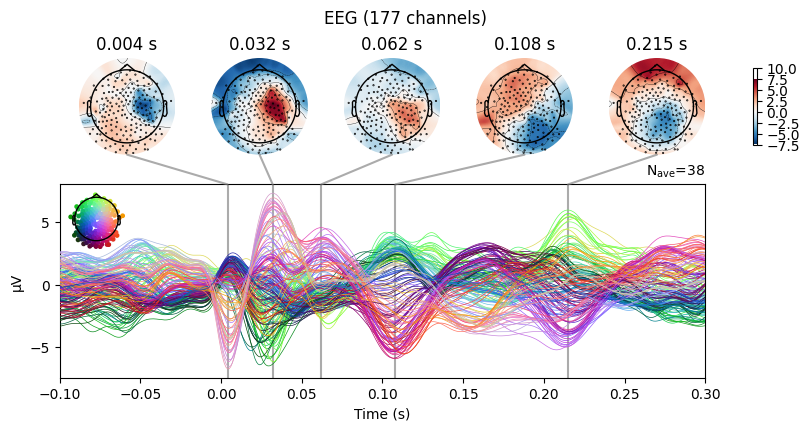

In [6]:
data_path = '/content/Data/EEG_stim/'
os.chdir(data_path)
file_name = 'sub-02_run-01_epoched.fif'

epoched = mne.read_epochs(data_path + file_name, verbose=False);

evoked = epoched.average()
ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.015);
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.03, tmax=0.05);
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.05, tmax=0.08);
ch, peak_locs4 = evoked.get_peak(ch_type='eeg', tmin=0.08, tmax=0.15);
ch, peak_locs5 = evoked.get_peak(ch_type='eeg', tmin=0.2, tmax=0.25);

ts_args = dict(xlim=[-0.1,0.3]) #Time to plot

times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5]

evoked_joint_st = evoked.plot_joint(ts_args=ts_args, times=times);

As you can see we have plot 100ms of baseline/resting-state activity. At 0ms a stimulus was delivered to the right SomatoMotor Network. And we track the waving propagation that generate from this perturbation. This is defined in literature as pertubation mapping approch. That's the empirical data that we want to model and specifically we want to explore what's the role of the structural connectivity in shaping this propagtion pattern

In order to answer this question we use a whole-brain models approach. We have alrady modelled the data for you due for saving time. Specifically we have used  Jansen & Ritt in `WhoBPyT`. The nature and purpose of the simulation is not really the main focus of this tutorial but - in a nutshell - we cast the differential equations of the model in a   `PyTorch` enviroment and using a deep-learning framework for finding the optimal paraters of the model which gave a good resemble of the empirical data in model generated timeseries.

Let's import the simulated timeseries and plot them using `plot_joint` again

No projector specified for this dataset. Please consider the method self.add_proj.


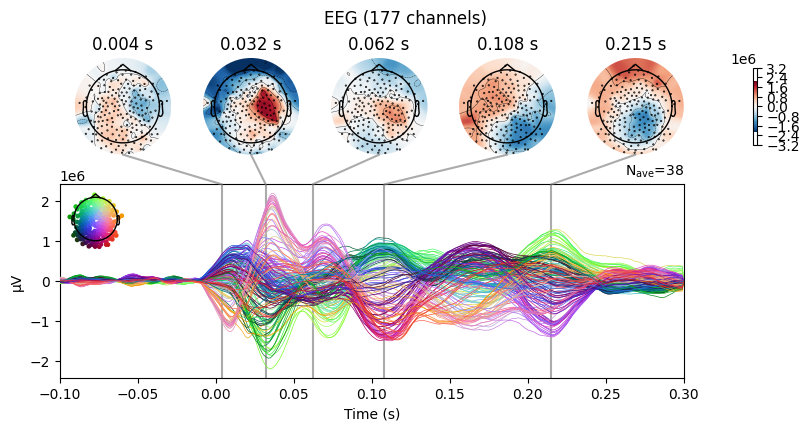

In [7]:
with open('/content/Data/EEG_stim/sub-02_run-01_fittingresults_stim_exp.pkl', 'rb') as f:
    data = pickle.load(f)

simulated_EEG_st = evoked.copy()


time_start = np.where(evoked.times==-0.1)[0][0]
time_end = np.where(evoked.times==0.3)[0][0]


simulated_EEG_st.data[:,time_start:time_end] = data.output_sim.eeg_test
times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5]
simulated_joint_st = simulated_EEG_st.plot_joint(ts_args=ts_args, times=times)

As you can see from the topomap, the model is able to track the propagation pattern of the induced-activity quite reliably. In order to evaluate the "goodness" of this fit, we can compute the Pearson's correlation betweeen simulated and empirical timeseries

In [8]:
corr = np.corrcoef(simulated_EEG_st._data[:, time_start:time_end].flatten(), evoked._data[:, time_start:time_end].flatten())[0,1]
print('correlation coeffient is equal to ' + str(corr))


correlation coeffient is equal to 0.833032208538631


Now that we have a model who is reproducing the empirical timeseries, we can use that for investigation what is the role of structural connectivity in shaping the propagation pattern. In order to do that we are going to use a virtual lesion approach.

A crucial aspect to note is that, in order to simulate the activity of the entire brain, we integrated the Jansen & Rit model into each node of the Schaefer et al. 2018 parcellation, which divides the brain into 200 parcels and 7 Network.

> Schaefer A. et al. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. *Cerebral Cortex* 28:3095–3114. (2018), doi: 10.1093/cercor/bhx179.

This approach allowed us to capture the complex dynamics and interactions occurring within each specific region of the brain. By implementing the model at a finer scale within the parcellation, we aimed to achieve a more comprehensive and accurate representation of the whole-brain activity.

We are going to start by setting up the path for the Schaefer annotation files

In [9]:
# Grabbing the Schaefer2018_200Parcels_7Networks_order anootation file
files = ['lh.Schaefer2018_200Parcels_7Networks_order.annot', 'rh.Schaefer2018_200Parcels_7Networks_order.annot']
save_path = '/content/Data/EEG_stim/'

Now we are ready to plot the simulated activity into a surface. The `tp` variable in the code below stands for time point and indicates the frame that it is going to be plotted into the surface.

First we are going to define some function for plotting the activity we have simulated into a brain surface

In [10]:
from matplotlib.tri import Triangulation

def get_rotation_matrix(rotation_axis, deg):

  '''Return rotation matrix in the x,y,or z plane'''



  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians

  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])



def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around
     the x,y,or z axes'''
  rotmat = np.eye(3)

  if type(rotations) is tuple: rotations = [rotations]
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat

def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(3,2), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):

  r"""Plot surfaces, surface patterns, and region patterns with matplotlib

  This is a general-use function for neuroimaging surface-based data, and
  does not necessarily require construction of or interaction with tvb
  datatypes.

  See also:  plot_surface_mpl_mv



  Parameters
  ----------

  vtx           : N vertices x 3 array of surface vertex xyz coordinates

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping
                  (N regions x 1 array), in which case the region mapping
                  bust also be given as an argument.

  rm            : region mapping - N vertices x 1 array with (up to) N
                  regions unique values; each element specifies which
                  region the corresponding surface vertex is mapped to

  reorient      : modify the vertex coordinate frame and/or orientation
                  so that the same default rotations can subsequently be
                  used for image views. The standard coordinate frame is
                  xyz; i.e. first,second,third axis = left-right,
                  front-back, and up-down, respectively. The standard
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.

                  Options:

                    tvb (default)   : swaps the first 2 axes and applies a rotation

                    fs              : for the standard freesurfer (RAS) orientation;
                                      e.g. fsaverage lh.orig.
                                      No transformations needed for this; so is
                                      gives same result as reorient=None

  view          : specify viewing angle.

                  This can be done in one of two ways: by specifying a string
                  corresponding to a standard viewing angle, or by providing
                  a tuple or list of tuples detailing exact rotations to apply
                  around each axis.

                  Standard view options are:

                  lh_lat / lh_med / rh_lat / rh_med /
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial
                   surfaces will not be visible, so e.g. 'rh_med' will look the
                   same as 'lh_lat')

                  Arbitrary rotations can be specied by a tuple or a list of
                  tuples, each with two elements, the first defining the axis
                  to rotate around [0,1,2], the second specifying the angle in
                  degrees. When a list is given the rotations are applied
                  sequentially in the order given.

                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees
                  rotation around the first axis, followed by 45 degrees rotate
                  around the second axis.

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below /
                  above these values

  nz_thr        : near-zero threshold - set to zero all datapoints with absolute
                  values smaller than this number. Default is a very small
                  number (1E-20), which unless your data has very small numbers,
                  will only mask out actual zeros.

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):

                    - 'shading'        (either 'gourand' or omit;
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual
                                       effect of this will depend on both the
                                       surface density and the figure size
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity

  ax            : figure axis

  figsize       : figure size (ignore if ax provided)

  title         : text string to place above figure




  Usage
  -----


  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})


  """

  # Copy things to make sure we don't modify things
  # in the namespace inadvertently.

  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle

  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order
    # yxz for some reason. So first change that:
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()

    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)



  # ...get rotations for standard view options

  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view

  # (rh_lat is the default 'view' argument because no rotations are
  #  for that one; so if no view is specified when the function is called,
  #  the 'rh_lat' option is chose here and the surface is shown 'as is'


  # ...apply rotations

  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)



  # 2. Sort out the data


  # ...if no data is given, plot a vector of 1s.
  #    if using region data, create corresponding surface vector
  if data is None:
    data = np.ones(vtx.shape[0])
  elif data.shape[0] != vtx.shape[0]:
    data = np.array([data[r] for r in rm])

  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)


  # 3. Create the surface triangulation object

  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])

  # 4. Make the figure

  if ax is None: fig, ax = plt.subplots(figsize=figsize)

  #if shade = 'gouraud': shade_opts['shade'] =
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)

  ax.set_aspect('equal')
  ax.axis('off')

  if title is not None: ax.set_title(title)
  return tc
#@title function for plotting surface

def plot_surface_mpl_mv(vtx=None,tri=None,data=None,rm=None,hemi=None,   # Option 1
                        vtx_lh=None,tri_lh=None,data_lh=None,rm_lh=None, # Option 2
                        vtx_rh=None,tri_rh=None,data_rh=None,rm_rh=None,
                        title=None, path = None, **kwargs):

  r"""Convenience wrapper on plot_surface_mpl for multiple views

  This function calls plot_surface_mpl five times to give a complete
  picture of a surface- or region-based spatial pattern.

  As with plot_surface_mpl, this function is written so as to be
  generally usable with neuroimaging surface-based data, and does not
  require construction of of interaction with tvb datatype objects.

  In order for the medial surfaces to be displayed properly, it is
  necessary to separate the left and right hemispheres. This can be
  done in one of two ways:

  1. Provide single arrays for vertices, faces, data, and
     region mappings, and addition provide arrays of indices for
     each of these (vtx_inds,tr_inds,rm_inds) with 0/False
     indicating left hemisphere vertices/faces/regions, and 1/True
     indicating right hemisphere.

     Note: this requires that

  2. Provide separate vertices,faces,data,and region mappings for
     each hemisphere (vtx_lh,tri_lh; vtx_rh,tri_rh,etc...)



  Parameters
  ----------

  (see also plot_surface_mpl parameters info for more details)

  (Option 1)

  vtx               :  surface vertices

  tri               : surface faces

  data              : spatial pattern to plot

  rm                : surface vertex to region mapping

  hemi              : hemisphere labels for each vertex
                      (1/True = right, 0/False = left) -


  OR

  (Option 2)

  vtx_lh            : left hemisphere surface_vertices
  vtx_rh            : right ``      ``    ``     ``

  tri_lh            : left hemisphere surface faces
  tri_rh            : right ``      ``    ``     ``

  data_lh          : left hemisphere surface_vertices
  data_rh          : right ``      ``    ``     ``

  rm_lh            : left hemisphere region_mapping
  rm_rh            : right ``      ``    ``     ``


  title            : title to show above middle plot

  kwargs           : additional tripcolor kwargs; see plot_surface_mpl



  Examples
  ----------

  # TVB default data

  # Plot one column of the region-based tract lengths
  # connectivity matrix. The corresponding region is
  # right auditory cortex ('rA1')

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                      hemi=isrh_vtx,title=u'rA1 \ntract length')

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                    hemi=isrh_vtx,title=u'rA1 \ntract length',
                    shade_kwargs = {'shading': 'gouraud',
                                    'cmap': 'rainbow'})


  """



  if vtx is not None:                                    # Option 1
    tri_hemi = hemi[tri].any(axis=1)
    tri_lh,tri_rh = tri[tri_hemi==0],tri[tri_hemi==1]
  elif vtx_lh is not None:                               # Option 2
    vtx = np.vstack([vtx_lh,vtx_rh])
    tri = np.vstack([tri_lh,tri_rh+tri_lh.max()+1])

  if data_lh is not None:                                # Option 2
    data = np.hstack([data_lh,data_rh])

  if rm_lh is not None:                                  # Option 2
    rm = np.hstack([rm_lh,rm_rh + rm_lh.max() + 1])



  # 2. Now do the plots for each view

  # (Note: for the single hemispheres we only need lh/rh arrays for the
  #  faces (tri); the full vertices, region mapping, and data arrays
  #  can be given as arguments, they just won't be shown if they aren't
  #  connected by the faces in tri )
  fig, ax = plt.subplots(2,3, figsize=(15,10))
  # LH lateral
  plot_surface_mpl(vtx,tri_lh,data=data,rm=rm,view='lh_lat',
                   ax=subplot(2,3,1),**kwargs)

  # LH medial
  plot_surface_mpl(vtx,tri_lh, data=data,rm=rm,view='lh_med',
                   ax=subplot(2,3,4),**kwargs)

  # RH lateral
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_lat',
                   ax=subplot(2,3,3),**kwargs)

  # RH medial
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_med',
                   ax=subplot(2,3,6),**kwargs)

  # Both superior
  im =plot_surface_mpl(vtx,tri, data=data,rm=rm,view='superior',
                   ax=subplot(1,3,2),title=title,**kwargs)

  plt.subplots_adjust(left=0.0, right=.8, bottom=0.0,
                      top=.8, wspace=0, hspace=0)
  #@title function for plot brain in one picture

In [ ]:
lh_annot = nib.freesurfer.io.read_annot(save_path + files[0])[0]
rh_annot = nib.freesurfer.io.read_annot(save_path + files[1])[0]

rh_annot_nl = rh_annot+np.max(rh_annot)
rh_annot_nl[rh_annot_nl == 100] = 0
reg_map = np.concatenate([lh_annot, rh_annot_nl])
hemi = np.ones_like(reg_map)

hemi[:reg_map.shape[0]//2] = 0

lhp_vtx_new,lhp_tri_new = nib.freesurfer.read_geometry(save_path + '/rh+lh.pial')

Now we are ready to plot the activity on the surface. As default it is set to 180, which corresponds to 80ms after the stimulation (considering the first 100ms/100time points are baseline)

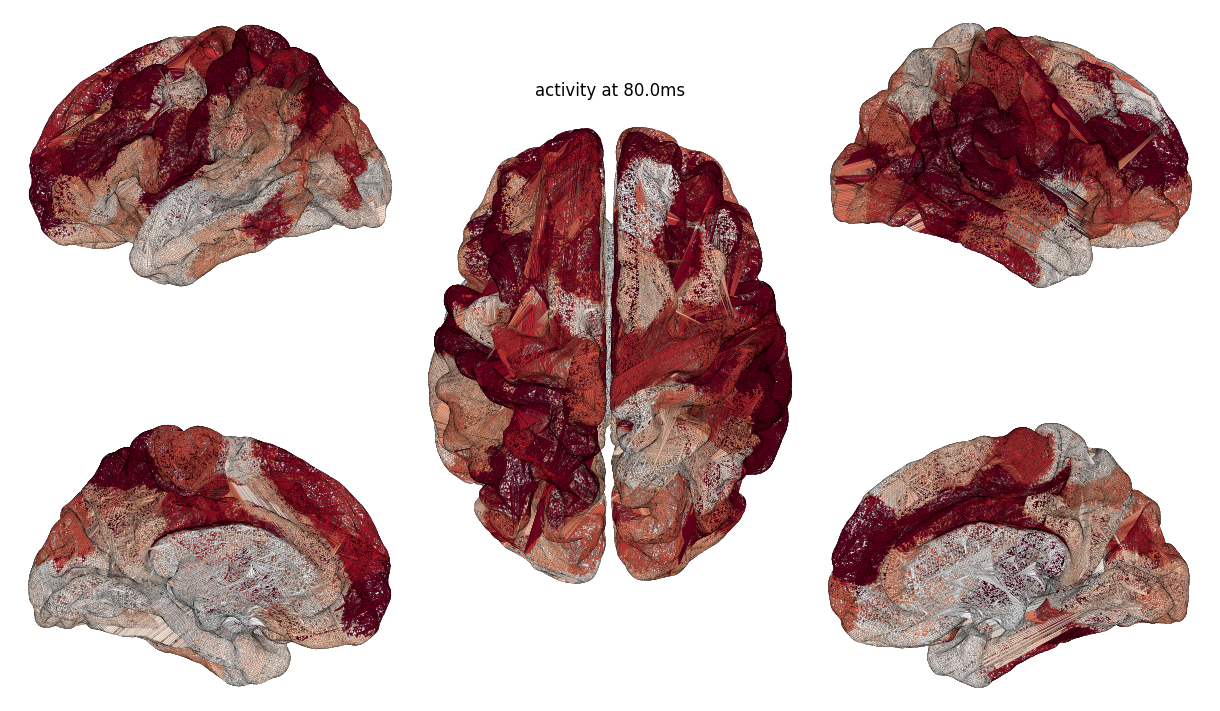

In [ ]:
tp = 180

data_pos = np.abs(data.output_sim.P_test[:,tp])
data2plot = np.concatenate([0*data_pos.max()*np.ones((1)),data_pos])[reg_map]

kws = {'edgecolors': 'k', 'cmap':  'RdBu_r', #$ 'Reds_r', #RdBu_r', # jet',
       'vmax':  np.mean(data.output_sim.P_test) + 0.05,
       'vmin': -(np.mean(data.output_sim.P_test) + 0.05), 'alpha': None, 'linewidth': 0.05}


plot_surface_mpl_mv(vtx=lhp_vtx_new, tri=lhp_tri_new, data=data2plot, reorient='fs', hemi=hemi, rm=reg_map, shade_kwargs=kws,
                    title='activity at ' + str(epoched.times[tp+200] * 1000) + 'ms')





By running the following cell, we will generate a visualization in the form of a movie that showcases the activity of the system over time.

In [ ]:
from IPython.display import Image

# Specify the path of the .gif file
gif_path = 'intact_source_brain_activity.gif'

# Display the .gif file
display(Image(filename=gif_path))

#@title #plot movie


Output hidden; open in https://colab.research.google.com to view.

So far the simulation has been run using an intact structural connectome. Now we are going to apply some lesion to the structural connectome 😈😛✂️ to investigate if it would affect the propagation pattern induced by the external pertubation.

We have developed an interactive window for exploration. It provides four adjustable parameters to analyze the effects:

- `threshold': This parameter represents the percentage of connections to be preserved. For instance, a value of 90 indicates that 10% of the connections will be damaged.
- `when_damage`: This parameter specifies the time in milliseconds (ms) after the stimulation when the damage is applied. For example, a value of 20 means that the damage will occur 20 ms after the stimulation.
- `direction`: This parameter determines which connections will be damaged. The options are 'both', 'forward', and 'backward'.
- `type_of_damage`: This parameter defines the type of damage to be applied. The options are 'target attack' or 'random attack'. 'Target attack' refers to removing the node's most relevant connection for stimulus propagation, while 'random attack' involves randomly selecting the node's connections to damage.

Please takes some time to explore how all this possible combination will affect the propagation pattern

0.4601344386898235 cos_sim:  0.2997026822199061
0.9413428241348791 cos_sim:  0.026015231129262528
No projector specified for this dataset. Please consider the method self.add_proj.


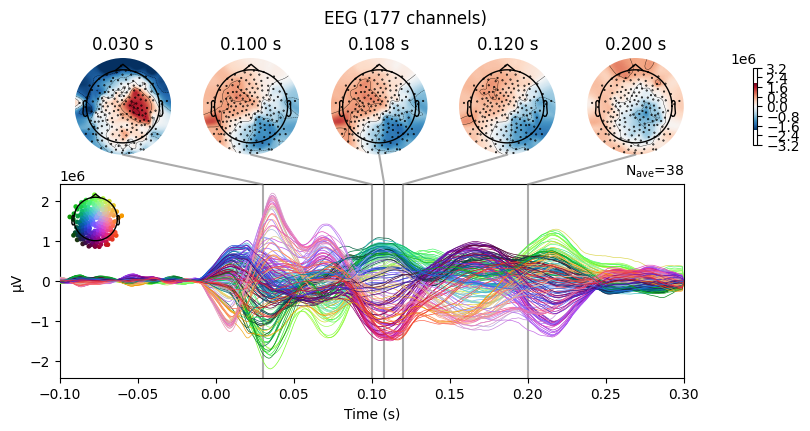

No projector specified for this dataset. Please consider the method self.add_proj.


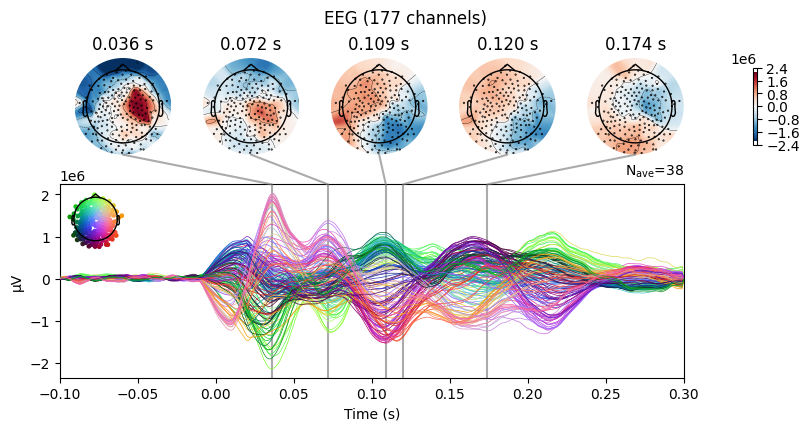

In [11]:
os.chdir('/content/Data/EEG_stim/')

def myround(x, base=5):
    return base * round(x/base)


node_size = 200
step_size = 0.0001
tr = 0.001
time_dim = 400
hidden_size = int(tr/step_size)
base_batch_num = 0
node_size = 200
state_size = 6
state_lb = -0.5
state_ub = 0.5
delays_max = 500
transient_num = 10
final_ouput = []
final_ouput_eeg = []

with open('sub-02_run-01_fittingresults_stim_exp.pkl', 'rb') as f:
    data = pickle.load(f)

threshold = "95" # @param [80, 85, 90, 95, 99]
threshold = int(threshold)
threshold = threshold/100


when_damage = "20" # @param [20, 40, 60, 100]
when_damage = int(when_damage)
when_damage = when_damage + 100


direction = 'both' # @param ['both', 'forward', 'feedback']
type_of_damage = 'random attack' # @param ['target attack', 'random attack']

damage_strength = -10
source_data = data.output_sim.P_test
degree = np.sum(np.abs(source_data), axis=1)
ref_value = (np.mean(degree) + (2.0* np.std(degree))) * threshold
indices = np.unique(np.where(degree>=ref_value)[0])


x0 = torch.tensor(np.random.uniform(state_lb, state_ub, (data.model.node_size, data.model.state_size)),
                         dtype=torch.float32)
he0 = torch.tensor(np.random.uniform(state_lb, state_ub, (data.model.node_size, delays_max)),
                    dtype=torch.float32)
empirical_ts = np.zeros((1, evoked.data.shape[0], evoked.data.shape[1]))
empirical_ts[0] = evoked.data


#0-150ms
u = np.zeros((200,10,when_damage))

u[:,:,90:120]= 1000
data.ts = data.ts[:,:(int(when_damage * 20/ 400)),:,:]
data.ts[0]  = np.reshape(empirical_ts[0,:,200:200+when_damage], (int(when_damage * 20/ 400), 185, 20))
data.test(x0, he0, 20, u=u)
final_ouput.append(data.output_sim.P_test)
final_ouput_eeg.append(data.output_sim.eeg_test)
x0 = torch.tensor(np.array([data.output_sim.P_test[:,-1],
                            data.output_sim.E_test[:,-1],
                            data.output_sim.I_test[:,-1],
                            data.output_sim.Pv_test[:,-1],
                            data.output_sim.Ev_test[:,-1],
                            data.output_sim.Iv_test[:,-1]]).T)

he0 = torch.tensor(np.concatenate([data.output_sim.P_test[:,::-1],
                      he0.detach().numpy()[:,:500-data.output_sim.E_test.shape[1]]], axis=1))


#100-400ms
with open('sub-02_run-01_fittingresults_stim_exp.pkl', 'rb') as f:
    data = pickle.load(f)

empirical_ts = np.zeros((1, evoked.data.shape[0], evoked.data.shape[1]))
empirical_ts[0] = evoked.data
u = np.zeros((200,10,int(400-when_damage)))
data.ts = data.ts[:,:(int((400-when_damage) * 20/ 400)),:,:]
data.ts[0]  = np.reshape(empirical_ts[0,:,200+when_damage:600], (int((400-when_damage) * 20/ 400), 185, 20))
original = data.model.w_ll.detach().numpy()
wll = data.model.w_ll.detach().numpy().copy()


if type_of_damage == 'random attack':
  random_values = []
  for _ in range(indices.shape[0]):
      random_value = random.randint(0, 199)
      random_values.append(random_value)
  indices = np.array(random_value)

if direction=='forward':
    wll[:, indices] = damage_strength
elif direction=='feedback':
    wll[indices, :] = damage_strength
elif direction=='both':
    wll[:, indices] = damage_strength
    wll[indices, :] = damage_strength


data.model.w_ll = Parameter(torch.tensor(wll, dtype=torch.float32))

data.test(x0, he0, 0, u=u)
final_ouput.append(data.output_sim.P_test)
final_ouput_eeg.append(data.output_sim.eeg_test)
new_ts = np.concatenate((final_ouput[0], final_ouput[1]), axis=1)
new_eeg = np.concatenate((final_ouput_eeg[0], final_ouput_eeg[1]), axis=1)


epoched = mne.read_epochs(file_name, verbose=False)
evoked = epoched.average()



with open('sub-02_run-01_fittingresults_stim_exp.pkl', 'rb') as f:
    data = pickle.load(f)

simulated_EEG_st = evoked.copy()

simulated_EEG_st.data[:,200:600] = data.output_sim.eeg_test


ts_args = dict(xlim=[-0.1,0.3])

ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.03)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.05, tmax=0.1)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.12)
ch, peak_locs4 = evoked.get_peak(ch_type='eeg', tmin=0.12, tmax=0.15)
ch, peak_locs5 = evoked.get_peak(ch_type='eeg', tmin=0.15, tmax=0.20)

times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5]


plot = simulated_EEG_st.plot_joint(ts_args=ts_args, times=times);



simulated_EEG_st_lesion = evoked.copy()

simulated_EEG_st_lesion.data[:,200:600] = new_eeg
ch, peak_locs1 = simulated_EEG_st_lesion.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.05)
ch, peak_locs2 = simulated_EEG_st_lesion.get_peak(ch_type='eeg', tmin=0.05, tmax=0.1)
ch, peak_locs3 = simulated_EEG_st_lesion.get_peak(ch_type='eeg', tmin=0.1, tmax=0.12)
ch, peak_locs4 = simulated_EEG_st_lesion.get_peak(ch_type='eeg', tmin=0.12, tmax=0.15)
ch, peak_locs5 = simulated_EEG_st_lesion.get_peak(ch_type='eeg', tmin=0.15, tmax=0.20)


times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5]

simulated_joint_st = simulated_EEG_st_lesion.plot_joint(ts_args=ts_args, times=times)

Now let's make the same plot than before (at the same time point) for the new simulation and explore how the lesion that we applied affects the propagation of the signal

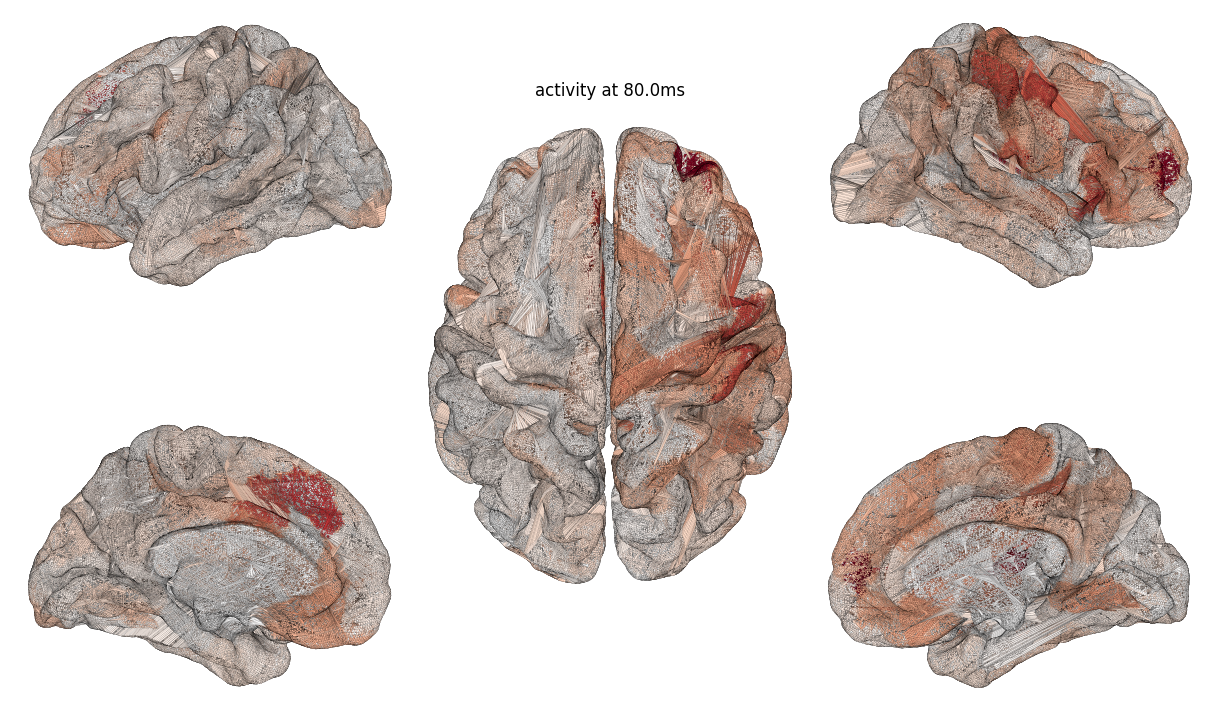

In [ ]:
tp = 180

data_pos = np.abs(new_ts[:,tp])
data2plot = np.concatenate([0*data_pos.max()*np.ones((1)),data_pos])[reg_map]

kws = {'edgecolors': 'k', 'cmap':  'RdBu_r', #$ 'Reds_r', #RdBu_r', # jet',
       'vmax':  np.mean(data.output_sim.P_test) + 0.05,
       'vmin': -(np.mean(data.output_sim.P_test) + 0.05), 'alpha': None, 'linewidth': 0.05}


plot_surface_mpl_mv(vtx=lhp_vtx_new, tri=lhp_tri_new, data=data2plot, reorient='fs', hemi=hemi, rm=reg_map, shade_kwargs=kws,
                    title='activity at ' + str(epoched.times[tp+200] * 1000) + 'ms')


In [ ]:
from IPython.display import Image

# Specify the path of the .gif file
gif_path = 'lesioned_source_brain_activity.gif'

# Display the .gif file
display(Image(filename=gif_path))

#@title #plot movie


Output hidden; open in https://colab.research.google.com to view.

Take a moment to compare this lesioned activity with the previous one 👀👀

#### **Propagation spreading of simulated stimulated-evoked activity**


In this section we are going to track the propagation spreading for the timeseries we have simulated.

**OUR GOAL**: WE want to track in which region the stimulus is propagating and the direction of that propation.  

 order to do that we are going to loop over the roi of the parcellations and we are going to collect the distance between two different time windows:
- source = [95:150]
- target = [125:180]


Remember stimulation was injected at 100


In [ ]:
with open('sub-02_run-01_fittingresults_stim_exp.pkl', 'rb') as f:
    data = pickle.load(f)

directional_matrix = np.zeros((200,200))


direction = np.zeros((200))

for roi_x in range(200):
  corr = np.zeros((200))
  for roi_y in range(200):
    corr[roi_y] = np.sum((data.output_sim.P_test[roi_x,95:150] - data.output_sim.P_test[roi_y,125:180])**2)

  direction[roi_x] = np.where(corr ==corr.min())[0][0]
  directional_matrix[roi_x,direction[roi_x].astype('int')] = 1/corr.min()

direction = direction.astype('int')
directional_matrix = directional_matrix / directional_matrix.max()

thr = 0.70
directional_matrix[directional_matrix<thr] = 0


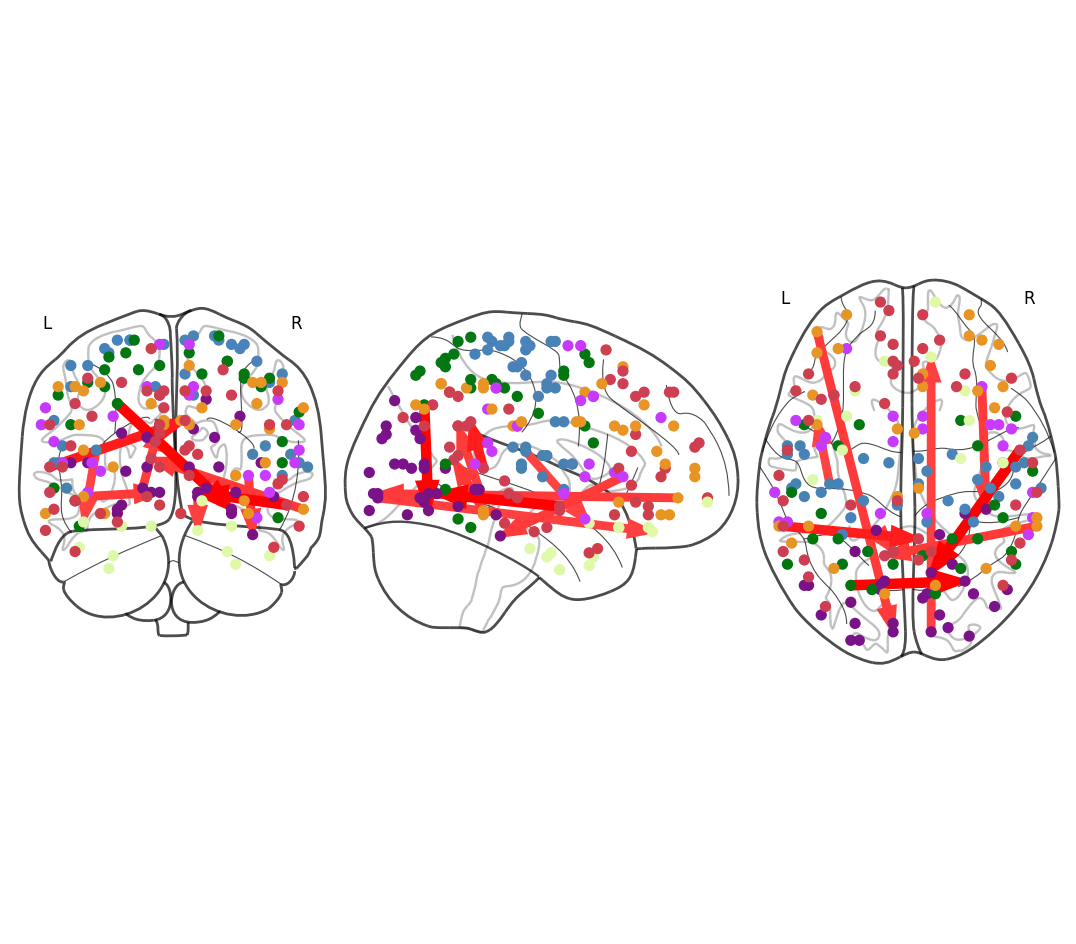

In [ ]:
net_colours = pd.read_excel('https://github.com/Davi1990/DissNet/raw/10755322a87e8ce8d22f0641651334f86088fc6d/examples/new_atlas_coords.xlsx',header=None)
RGB = np.array(([net_colours[2]/255.0, net_colours[3]/255.0, net_colours[4]/255.0]))
RGB = RGB[:,:200]

fig = plt.figure(figsize=(30, 12))
ax = plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1, fig=fig)
display = plotting.plot_connectome(directional_matrix, coords,
                                   node_color=RGB.T,
                                   axes=ax)


In [ ]:
plotting.view_connectome(directional_matrix, coords,
                                   node_color=RGB.T, edge_threshold="97%",
                                   )


Output hidden; open in https://colab.research.google.com to view.

Next we are going to use the equation from:

> Pang JC., Aquino KM, Oldehinkel M., Robinson PA., Fulcher BD., Breakspear M., Fornito A. (2023) **Geometric constraints on human brain function.** *Nature*, 618(7965):566-574. doi: 10.1038/s41586-023-06098-1.

<br/>
\begin{equation}
\left[\frac{1}{{\gamma_s}^2} \frac{{\partial^2 \phi}}{{\partial t^2}} + \frac{2}{\gamma_s} \frac{{\partial^2 \phi}}{{\partial t \partial s}} + 1 - {r_s}^2 {\nabla}^2 \phi\right] \phi(\mathbf{r}, t) = Q(\mathbf{r}, t)
\end{equation}
<br/>


Specifically we are going to estimate the $\phi(\mathbf{r}, t)$ for the timeseries we just modelled and see how the stimulus evkoed is travelling to the brain.
First we are going to import the atlas and compute the distance matrix which we will need to estimate ${\gamma_s}$

In [ ]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
  for roi2 in range(coords.shape[0]):
    distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
    distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))


 Next we are going to use the function `model_neural_waves_python()`. In our case:
 - the $Q(\mathbf{r}, t)$ is going to be the output of the model `data.output_sim.P_test`
 - the eigenvalues and eigenvectors are going to be the ouput of the structural connectivity matrix `np.linalg.svd(data.model.sc_fitted.detach().numpy())`



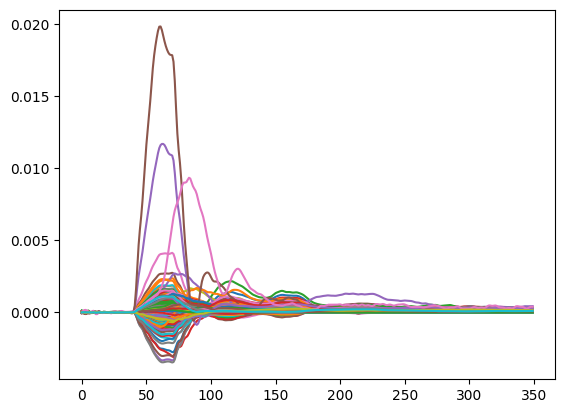

In [ ]:
sim_eigenvectors, sim_eigenvalues, sim_eigenvectors_v = np.linalg.svd(data.model.sc_fitted.detach().numpy())

n_mode = 5
method = 'ODE'
sim_eigenvectors[:,:n_mode]
# Simulate resting-state activity using Gaussian white noise
param = loadParameters_wave_func()
param['tstep'] = 1  # in ms
param['tmax'] = 400  # in ms
param['tspan'] = [0, param['tmax']]
param['T'] = np.arange(-0.1, param['tmax'] + param['tstep'], param['tstep'])[:-2]
# Change value of param.is_time_ms to 1 because the time defined above is
# in ms. This is necessary as param.gamma_s needs to match the scale.
param['is_time_ms'] = 0.4
param['r_s'] = 30 # (default) in mm
param['gamma_s'] =  distance.mean() / data.model.mu.detach().numpy() * 1e-3 # (default) in s^-1
if param['is_time_ms'] == 0.4:
    param['gamma_s'] =  distance.mean() / data.model.mu.detach().numpy() * 1e-3

sim_mode_activity_rest, sim_simulated_activity_rest = model_neural_waves_python(sim_eigenvectors[:,:n_mode],
                                                                              sim_eigenvalues[:n_mode],
                                                                              data.output_sim.P_test,
                                                                              param,
                                                                              method)
plt.plot(sim_simulated_activity_rest[:,50:].T);

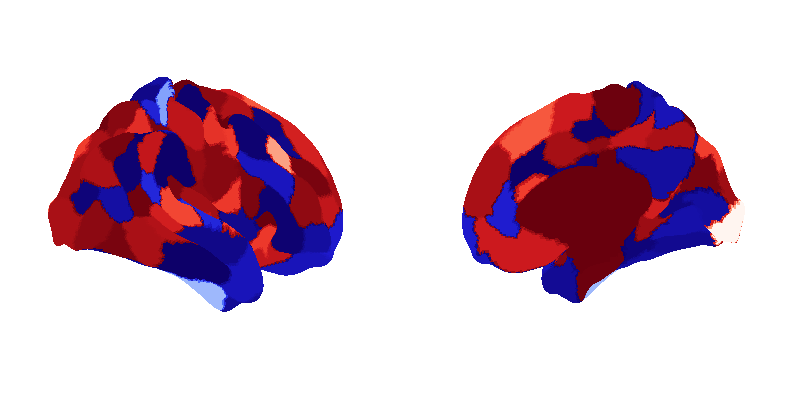

In [ ]:
hemisphere = 'rh'

roi_corr = sim_simulated_activity_rest[:,120]

filename = '../travelling_brain_waves/fsLR_32k_Schaefer200-rh.txt'

with open(filename, 'r') as file:
    contents = file.read()

numbers =np.array([int(num) for num in contents.split('\n') if num])


roi_map = np.zeros((lh_simulated_activity_rest.shape[0]))

for roi in range(1,np.unique(numbers).shape[0]):
  idx2use = np.where(numbers==roi+100)[0]
  roi_map[idx2use] = roi_corr[roi]


fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(8, 6))

for row, view in zip(axes, ['lateral', 'medial']):
    #for n, (col, hemi) in enumerate(zip(row, ['infl_left', 'infl_left'])):
        fn = '../travelling_brain_waves/fsLR_32kmidthickness-' + hemisphere + '.gii'

        if hemisphere=='rh':
          hemi = 'right'
        else:
          hemi = 'left'

        plotting.plot_surf_stat_map(fn,
                            stat_map=roi_map, hemi=hemi, view=view, axes=row,
                            colorbar=False, cmap='blue_red', vmax=roi_map.max())


fig.tight_layout()

## Conclusions

 This collaborative notebook has provided a comprehensive exploration of:
 - **Implementation of the Robinson-model single node in numpy:**
we successfully implemented the Robinson-model single node using the numpy library. By accurately replicating the model, we established a solid foundation for further analysis and exploration of brain dynamics.

- **Exploring the effects of diffusion coupling on brain dynamics:**
Using the Robinson-model, we delved into the influence of diffusion coupling on brain dynamics. Through our investigations, we uncovered how specific parameters related to diffusion coupling impact the integration and segregation structures within the brain.

- **Unveiling the emergence of brain functions from inner geometric structure features:** Through our exploration, we discovered that brain functions emerge from the inner geometric structure features of the brain. By studying the implemented model, we gained valuable insights into how these geometric characteristics contribute to the complex dynamics observed in the brain. This knowledge advances our understanding of the fundamental principles governing brain functionality.

- **Dissecting signal propagation dynamics using a brain stimulation model and virtual lesion approach:**
To further investigate signal propagation dynamics, we employed a brain stimulation model and a virtual lesion approach. This allowed us to dissect the intricate mechanisms involved in the transmission of signals within the brain. By simulating various scenarios and observing the effects of virtual lesions, we gained valuable insights into the network dynamics and connectivity patterns, providing a deeper understanding of brain function.

##References


> Breakspear M. (2017). **Dynamic models of large-scale brain activity.** *Nat Neurosci*, 15(1), 20(3):340-352. doi: 10.1038/nn.4497.

> David, O. and Friston, K.J. (2003) **A neural mass model for MEG/EEG: coupling and neuronal dynamics.** *Nat Neurosci*, 0:340–352. doi:10.1038/nn.4497.

> Jansen, B.H. and Rit, V.G. (1995) **Electroencephalogram and visual evoked potential generation in a mathematical model of coupled cortical columns.** *Biological cybernetics*, 73(4), pp.357-366.

> Jirsa VK, Proix T, Perdikis D, Woodman MM, Wang H, Gonzalez-Martinez J, Bernard C, Bénar C, Guye M, Chauvel P, Bartolomei F. (2017) **The Virtual Epileptic Patient: Individualized whole-brain models of epilepsy spread.** *NeuroImage*, 145:377–388. doi:10.1016/j.neuroimage.2016.04.049.

> Jirsa VK, Stacey WC, Quilichini PP, Ivanov AI, Bernard C. (2017) **On the nature of seizure dynamics.** *Brain J Neurol*, 137:2210–2230. doi:10.1093/brain/awu133.

> Momi, D., Wang, Z., Griffiths, J.D. (2023). **TMS-Evoked Responses Are Driven by Recurrent Large-Scale Network Dynamics.** *eLife*, 111, pp.385-430.

> Munn BR., Müller EJ., Wainstein G., Shine JM. (2021) **The ascending arousal system shapes neural dynamics to mediate awareness of cognitive states** *Nature Communications*, 12, 6016 doi: 10.1038/s41467-021-26268-x

> Pang JC., Aquino KM, Oldehinkel M., Robinson PA., Fulcher BD., Breakspear M., Fornito A. (2023) **Geometric constraints on human brain function.** *Nature*, 618(7965):566-574. doi: 10.1038/s41586-023-06098-1.

> Roberts JA, Gollo LL., Abeysuriya RG., Roberts G., Mitchell PG, Woolrich MW,  Breakspear B. (2019) **Metastable brain waves.** *Nat Commun*, 10(1):1056. doi: 10.1038/s41467-019-08999-0.

> Robinson PA., Rennie CJ., Wright JJ. (1997) **Propagation and stability of waves of electrical activity in the cerebral cortex.** *Physical Review*, 56, 826  doi: 10.1103/PhysRevE.56.826.

> Robinson PA., Rennie CJ., Rowe DL., O'Connor SC., Wright JJ., Gordon E., Whitehouse RW. (2003) **Neurophysical modeling of brain dynamics.** *Neuropsychopharmacology*, 1:S74-9. doi: 10.1038/sj.npp.1300143.

> Suárez LE, Richards BA, Lajoie G., Misic B. (2021) **Learning function from structure in neuromorphic networks.** *Nature Machine Intelligence*, 3, pp.771–786.

> Shine JM., Breakspear M., Bell PT., Ehgoetz Martens KA., Shine R., Koyejo O., Sporns O., Poldrack RA. (2019). **Human cognition involves the dynamic integration of neural activity and neuromodulatory systems.** *Nat Neurosci* 22:289–296. doi:10.1038/s41593-018-0312-0.


